# CodeStates AI Section2 Project

AI_15_정경재

- Project : Hypertension Predictive Model
- 프로젝트 : 한국형 고혈압 예측 모델 개발
    - 고혈압 진단기준에 따른 차이가 있을까?

# Final model Interpretation

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

## 0. Data

In [2]:
df0 = pd.read_csv('data/KNHANES_8th_final2.csv')
df1 = df0.iloc[:,2:]
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11422 entries, 0 to 11421
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sex            11422 non-null  int64  
 1   age            11422 non-null  int64  
 2   heavy_drink    11422 non-null  int64  
 3   smoke          11422 non-null  int64  
 4   genetic_hbp    11422 non-null  float64
 5   BMI            11422 non-null  float64
 6   diabetes       11422 non-null  int64  
 7   hyper_chol     11422 non-null  int64  
 8   triglycerides  11422 non-null  float64
 9   HBP_US         11422 non-null  int64  
 10  HBP_EU         11422 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 981.7 KB


In [3]:
train, test = train_test_split(df1,test_size=0.2,random_state=42)

features = df1.drop(columns=['HBP_US','HBP_EU']).columns
target_us = 'HBP_US'
target_eu = 'HBP_EU'

X_train = train[features]
y_train_us = train[target_us]
y_train_eu = train[target_eu]

X_test = test[features]
y_test_us = test[target_us]
y_test_eu = test[target_eu]

print('분리전 : {}\n'.format(df1.shape))
print('훈련&검증데이터 : {}'.format(train.shape))
print('테스트데이터 : {}'.format(test.shape))

print('X y 분리 후 shape\n')
print('X_train : {}'.format(X_train.shape))
print('y_train(US) : {}'.format(y_train_us.shape))
print('y_train(EU) : {}\n'.format(y_train_eu.shape))
print('X_test : {}'.format(X_test.shape))
print('y_test(US) : {}'.format(y_test_us.shape))
print('y_test(EU) : {}'.format(y_test_eu.shape))

분리전 : (11422, 11)

훈련&검증데이터 : (9137, 11)
테스트데이터 : (2285, 11)
X y 분리 후 shape

X_train : (9137, 9)
y_train(US) : (9137,)
y_train(EU) : (9137,)

X_test : (2285, 9)
y_test(US) : (2285,)
y_test(EU) : (2285,)


## 1-0. Baseline

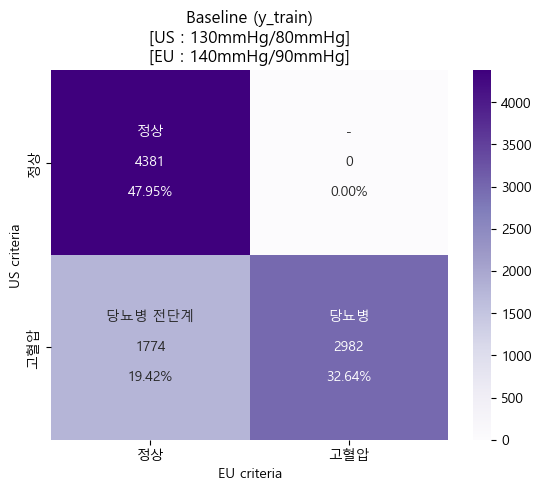

In [4]:
cfm_baseline_us = confusion_matrix(y_train_us,y_train_eu)
group_names_baseline_us = ['정상','-','당뇨병 전단계','당뇨병']
group_counts_baseline_us = ['{0:0.0f}'.format(value) for value in cfm_baseline_us.flatten()]
group_percentages_baseline_us = ['{0:.2%}'.format(value) for value in cfm_baseline_us.flatten()/np.sum(cfm_baseline_us)]
labels_baseline_us = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_baseline_us,group_counts_baseline_us,group_percentages_baseline_us)]
labels_baseline_us = np.asarray(labels_baseline_us).reshape(2,2)
tick_baseline_us = ['정상','고혈압']
sns.heatmap(cfm_baseline_us, annot=labels_baseline_us, fmt='',cmap='Purples',xticklabels=tick_baseline_us,yticklabels=tick_baseline_us)
plt.xlabel('EU criteria')
plt.ylabel('US criteria')
plt.title('Baseline (y_train)\n[US : 130mmHg/80mmHg]\n[EU : 140mmHg/90mmHg]')
plt.show()

### US criteria

In [5]:
base_us = y_train_us.mode()[0]
baseline_us = [base_us]*len(y_train_us)
print("Baseline accuracy(US): {}".format(
    accuracy_score(y_train_us, baseline_us)))
print("Baseline AUC_score(US): {}".format(
    roc_auc_score(y_train_us, baseline_us)))

Baseline accuracy(US): 0.5205209587391922
Baseline AUC_score(US): 0.5


### EU criteria

In [6]:
base_eu = y_train_eu.mode()[0]
baseline_eu = [base_eu]*len(y_train_eu)
print("Baseline accuracy(EU): {}".format(
    accuracy_score(y_train_eu, baseline_eu)))
print("Baseline AUC_score(EU): {}".format(
    roc_auc_score(y_train_eu, baseline_eu)))

Baseline accuracy(EU): 0.6736346722118858
Baseline AUC_score(EU): 0.5


## 1-1. Final Model (XGBoost)

#### Modeling (US criteria)

- 최적 하이퍼파라미터 
    - 'objective': 'binary:logistic'
    - 'eval_metric': 'auc'
    - 'n_estimators': 200
    - 'learning_rate': 0.05
    - 'max_depth': 2
    - 'min_child_weight': 4
    - 'subsample': 0.2
    - 'colsample_bytree': 0.8
- 최적 roc_auc:  0.794148446162498

In [7]:
xgb_us_tun = XGBClassifier(
    n_jobs = -1,
    random_state = 42,
    objective = 'binary:logistic',
    eval_metric = 'auc',
    n_estimators = 200,
    learning_rate = 0.05,
    max_depth = 2,
    min_child_weight = 4,
    subsample = 0.2,
    colsample_bytree = 0.8
)

xgb_us_tun.fit(X_train,y_train_us)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=4,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [8]:
CV_score_accuracy_xgb_us_tun = cross_val_score(xgb_us_tun,X_train,y_train_us,cv=5,n_jobs=-1,scoring='accuracy')
CV_score_auc_xgb_us_tun = cross_val_score(xgb_us_tun,X_train,y_train_us,cv=5,n_jobs=-1,scoring='roc_auc')
print('[US criteria]\n')
print("Baseline accuracy(US): {}".format(accuracy_score(y_train_us, baseline_us)))
print('XGBClassifier accuracy(Final): {}\n'.format(CV_score_accuracy_xgb_us_tun.mean()))
print("Baseline AUC_score(US): {}".format(roc_auc_score(y_train_us, baseline_us)))
print('XGBClassifier AUC_score(Final) : {}'.format(CV_score_auc_xgb_us_tun.mean()))

[US criteria]

Baseline accuracy(US): 0.5205209587391922
XGBClassifier accuracy(Final): 0.7275927343195132

Baseline AUC_score(US): 0.5
XGBClassifier AUC_score(Final) : 0.794148446162498


#### Modeling (EU criteria)

- 최적 하이퍼파라미터 
    - 'objective': 'binary:logistic'
    - 'eval_metric': 'auc'
    - 'n_estimators': 200
    - 'learning_rate': 0.05
    - 'max_depth': 2
    - 'min_child_weight': 8
    - 'subsample': 0.3
    - 'colsample_bytree': 0.9
- 최적 roc_auc:  0.8380314251605574

In [9]:
xgb_eu_tun = XGBClassifier(
    n_jobs = -1,
    random_state = 42,
    objective = 'binary:logistic',
    eval_metric = 'auc',
    n_estimators = 200,
    learning_rate = 0.05,
    max_depth = 2,
    min_child_weight = 8,
    subsample = 0.3,
    colsample_bytree = 0.9
)

xgb_eu_tun.fit(X_train,y_train_eu)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=8,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [10]:
CV_score_accuracy_xgb_eu_tun = cross_val_score(xgb_eu_tun,X_train,y_train_eu,cv=5,n_jobs=-1,scoring='accuracy')
CV_score_auc_xgb_eu_tun = cross_val_score(xgb_eu_tun,X_train,y_train_eu,cv=5,n_jobs=-1,scoring='roc_auc')
print('[EU criteria]\n')
print("Baseline accuracy(EU): {}".format(accuracy_score(y_train_eu, baseline_eu)))
print('XGBClassifier accuracy(Final): {}\n'.format(CV_score_accuracy_xgb_eu_tun.mean()))
print("Baseline AUC_score(EU): {}".format(roc_auc_score(y_train_eu, baseline_eu)))
print('XGBClassifier AUC_score(Final) : {}'.format(CV_score_auc_xgb_eu_tun.mean()))

[EU criteria]

Baseline accuracy(EU): 0.6736346722118858
XGBClassifier accuracy(Final): 0.7719166310353212

Baseline AUC_score(EU): 0.5
XGBClassifier AUC_score(Final) : 0.8380314251605574


## 1-2. Final Model Validation & Test

### Final Model Evauation

#### US criteria

y_pred_us,0,1
y_real_us,,
0,2940,1441
1,1048,3708


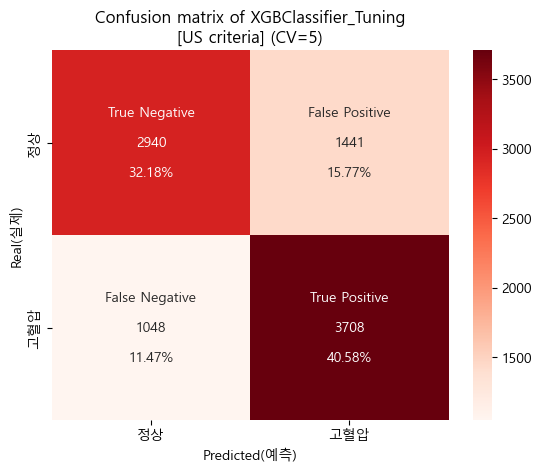

[US criteria]
Baseline accuracy(US): 0.5205209587391922
XGBClassifier_Tuning accuracy(US): 0.7275927343195132


In [11]:
CV_pred_final_us = cross_val_predict(xgb_us_tun,X_train,y_train_us,cv=5,n_jobs=-1)
df_final_us = pd.DataFrame(data={'y_real_us':y_train_us,
                                 'y_pred_us':CV_pred_final_us})
table_final_us = pd.crosstab(df_final_us['y_real_us'],df_final_us['y_pred_us'])
display(table_final_us)

cfm_final_us = confusion_matrix(y_train_us,CV_pred_final_us)
group_names_final_us = ['True Negative','False Positive','False Negative','True Positive']
group_counts_final_us = ['{0:0.0f}'.format(value) for value in cfm_final_us.flatten()]
group_percentages_final_us = ['{0:.2%}'.format(value) for value in cfm_final_us.flatten()/np.sum(cfm_final_us)]
labels_final_us = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_final_us,group_counts_final_us,group_percentages_final_us)]
labels_final_us = np.asarray(labels_final_us).reshape(2,2)
tick_final_us = ['정상','고혈압']
sns.heatmap(cfm_final_us, annot=labels_final_us, fmt='',cmap='Reds',xticklabels=tick_final_us,yticklabels=tick_final_us)
plt.xlabel('Predicted(예측)')
plt.ylabel('Real(실제)')
plt.title('Confusion matrix of XGBClassifier_Tuning\n[US criteria] (CV=5)')
plt.show()

CV_score_accuracy_final_us = cross_val_score(xgb_us_tun,X_train,y_train_us,cv=5,n_jobs=-1,scoring='accuracy')
print('[US criteria]')
print("Baseline accuracy(US): {}".format(accuracy_score(y_train_us, baseline_us)))
print('XGBClassifier_Tuning accuracy(US): {}'.format(CV_score_accuracy_final_us.mean()))

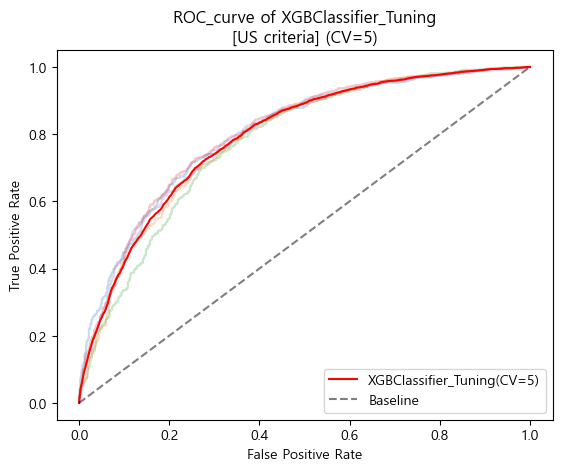

[US criteria]
Baseline AUC_score(US): 0.5
XGBClassifier_Tuning AUC_score(US) : 0.794148446162498


In [12]:
kf_5 = KFold(n_splits=5,shuffle=True,random_state=42)
tprs_final_us = []
base_fpr_final_us = np.linspace(0,1,300)

for train_idx, val_idx in kf_5.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_us_cv, y_val_us_cv = y_train_us.iloc[train_idx], y_train_us.iloc[val_idx]
    
    xgb_us_tun.fit(X_train_cv,y_train_us_cv)
    
    y_val_us_prob = xgb_us_tun.predict_proba(X_val_cv)[:,1]
    FPR_final_us, TPR_final_us, _ = roc_curve(y_val_us_cv,y_val_us_prob)
    
    plt.plot(FPR_final_us,TPR_final_us,alpha=.25)
    tpr_us = np.interp(base_fpr_final_us,FPR_final_us,TPR_final_us)
    tpr_us[0] = 0.0
    tprs_final_us.append(tpr_us)
tprs_final_us = np.array(tprs_final_us)
mean_tprs_final_us = tprs_final_us.mean(axis=0)
plt.plot(base_fpr_final_us,mean_tprs_final_us,label='XGBClassifier_Tuning(CV=5)',color='red')
plt.plot([0,1],[0,1],label='Baseline',color='black',linestyle='--',alpha=.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_curve of XGBClassifier_Tuning\n[US criteria] (CV=5)')
plt.legend(loc='lower right')
plt.show()

CV_score_auc_final_us = cross_val_score(xgb_us_tun,X_train,y_train_us,cv=5,n_jobs=-1,scoring='roc_auc')
print('[US criteria]')
print("Baseline AUC_score(US): {}".format(roc_auc_score(y_train_us, baseline_us)))
print('XGBClassifier_Tuning AUC_score(US) : {}'.format(CV_score_auc_final_us.mean()))

#### EU criteria

y_pred_eu,0,1
y_real_eu,,
0,5253,902
1,1182,1800


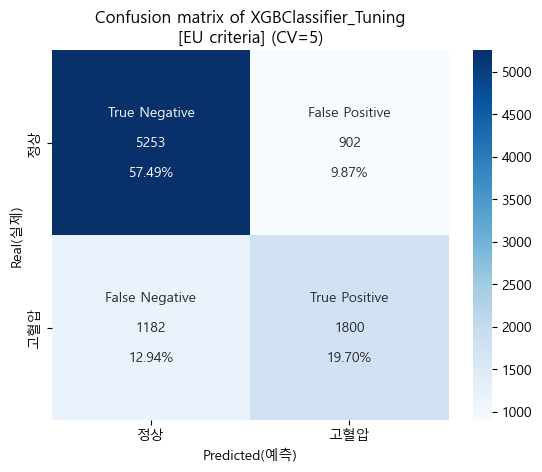

[EU criteria]
Baseline accuracy(EU): 0.6736346722118858
XGBClassifier_Tuning accuracy(EU): 0.7719166310353212


In [13]:
CV_pred_final_eu = cross_val_predict(xgb_eu_tun,X_train,y_train_eu,cv=5,n_jobs=-1)
df_final_eu = pd.DataFrame(data={'y_real_eu':y_train_eu,
                                 'y_pred_eu':CV_pred_final_eu})
table_final_eu = pd.crosstab(df_final_eu['y_real_eu'],df_final_eu['y_pred_eu'])
display(table_final_eu)

cfm_final_eu = confusion_matrix(y_train_eu,CV_pred_final_eu)
group_names_final_eu = ['True Negative','False Positive','False Negative','True Positive']
group_counts_final_eu = ['{0:0.0f}'.format(value) for value in cfm_final_eu.flatten()]
group_percentages_final_eu = ['{0:.2%}'.format(value) for value in cfm_final_eu.flatten()/np.sum(cfm_final_eu)]
labels_final_eu = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_final_eu,group_counts_final_eu,group_percentages_final_eu)]
labels_final_eu = np.asarray(labels_final_eu).reshape(2,2)
tick_final_eu = ['정상','고혈압']
sns.heatmap(cfm_final_eu, annot=labels_final_eu, fmt='',cmap='Blues',xticklabels=tick_final_eu,yticklabels=tick_final_eu)
plt.xlabel('Predicted(예측)')
plt.ylabel('Real(실제)')
plt.title('Confusion matrix of XGBClassifier_Tuning\n[EU criteria] (CV=5)')
plt.show()

CV_score_accuracy_final_eu = cross_val_score(xgb_eu_tun,X_train,y_train_eu,cv=5,n_jobs=-1,scoring='accuracy')
print('[EU criteria]')
print("Baseline accuracy(EU): {}".format(accuracy_score(y_train_eu, baseline_eu)))
print('XGBClassifier_Tuning accuracy(EU): {}'.format(CV_score_accuracy_final_eu.mean()))

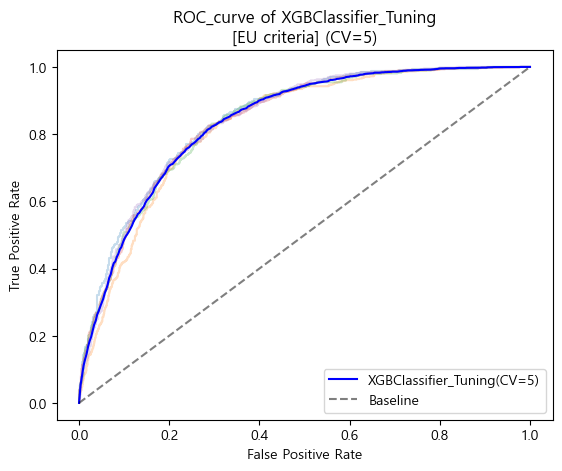

[EU criteria]
Baseline AUC_score(EU): 0.5
XGBClassifier_Tuning AUC_score(EU) : 0.8380314251605574


In [14]:
tprs_final_eu = []
base_fpr_final_eu = np.linspace(0,1,300)

for train_idx, val_idx in kf_5.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_eu_cv, y_val_eu_cv = y_train_eu.iloc[train_idx], y_train_eu.iloc[val_idx]
    
    xgb_eu_tun.fit(X_train_cv,y_train_eu_cv)
    
    y_val_eu_prob = xgb_eu_tun.predict_proba(X_val_cv)[:,1]
    FPR_final_eu, TPR_final_eu, _ = roc_curve(y_val_eu_cv,y_val_eu_prob)
    
    plt.plot(FPR_final_eu,TPR_final_eu,alpha=.25)
    tpr_eu = np.interp(base_fpr_final_eu,FPR_final_eu,TPR_final_eu)
    tpr_eu[0] = 0.0
    tprs_final_eu.append(tpr_eu)
tprs_final_eu = np.array(tprs_final_eu)
mean_tprs_final_eu = tprs_final_eu.mean(axis=0)
plt.plot(base_fpr_final_eu,mean_tprs_final_eu,label='XGBClassifier_Tuning(CV=5)',color='blue')
plt.plot([0,1],[0,1],label='Baseline',color='black',linestyle='--',alpha=.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_curve of XGBClassifier_Tuning\n[EU criteria] (CV=5)')
plt.legend(loc='lower right')
plt.show()

CV_score_auc_final_eu = cross_val_score(xgb_eu_tun,X_train,y_train_eu,cv=5,n_jobs=-1,scoring='roc_auc')
print('[EU criteria]')
print("Baseline AUC_score(EU): {}".format(roc_auc_score(y_train_eu, baseline_eu)))
print('XGBClassifier_Tuning AUC_score(EU) : {}'.format(CV_score_auc_final_eu.mean()))

#### US & EU

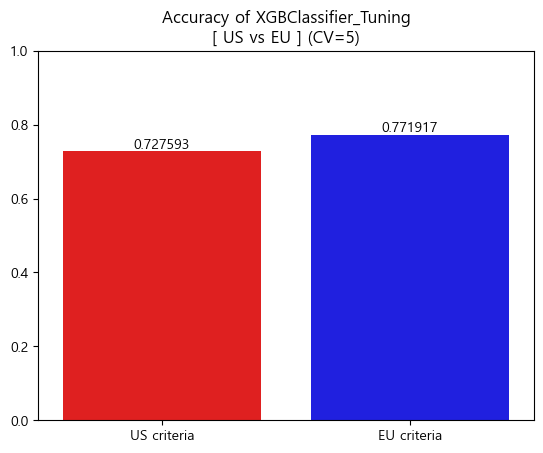

[Accuracy]

Baseline accuracy(US): 0.5205209587391922
Validation accuracy(US): 0.7275927343195132

Baseline accuracy(EU): 0.6736346722118858
Validation accuracy(EU): 0.7719166310353212



In [15]:
df_accuacy_final = pd.DataFrame({'US criteria':[CV_score_accuracy_final_us.mean()]
                                 ,'EU criteria':[CV_score_accuracy_final_eu.mean()]},
                                index=['Accuracy'])
ax = sns.barplot(data=df_accuacy_final,palette=['red','blue'])
ax.bar_label(ax.containers[0])
plt.title('Accuracy of XGBClassifier_Tuning\n[ US vs EU ] (CV=5)')
plt.ylim(0,1)
plt.show()

print('[Accuracy]\n')
print("Baseline accuracy(US): {}".format(accuracy_score(y_train_us, baseline_us)))
print('Validation accuracy(US): {}\n'.format(CV_score_accuracy_final_us.mean()))
print("Baseline accuracy(EU): {}".format(accuracy_score(y_train_eu, baseline_eu)))
print('Validation accuracy(EU): {}\n'.format(CV_score_accuracy_final_eu.mean()))

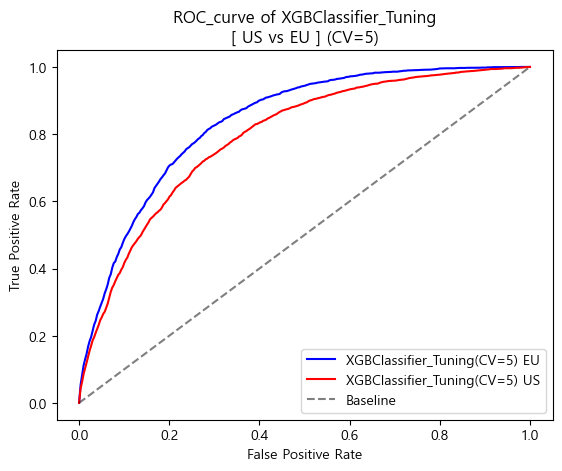

[AUC_score]
XGBClassifier_Tuning AUC_score(US) : 0.794148446162498
XGBClassifier_Tuning AUC_score(EU) : 0.8380314251605574


In [16]:
plt.plot(base_fpr_final_eu,mean_tprs_final_eu,label='XGBClassifier_Tuning(CV=5) EU',color='blue')
plt.plot(base_fpr_final_us,mean_tprs_final_us,label='XGBClassifier_Tuning(CV=5) US',color='red')
plt.plot([0,1],[0,1],label='Baseline',color='black',linestyle='--',alpha=0.5)
plt.title('ROC_curve of XGBClassifier_Tuning\n[ US vs EU ] (CV=5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
print('[AUC_score]')
print('XGBClassifier_Tuning AUC_score(US) : {}'.format(CV_score_auc_final_us.mean()))
print('XGBClassifier_Tuning AUC_score(EU) : {}'.format(CV_score_auc_final_eu.mean()))

### Final Model Test

#### US criteria

y_pred_us,0,1
y_real_us,,
0,711,392
1,306,876


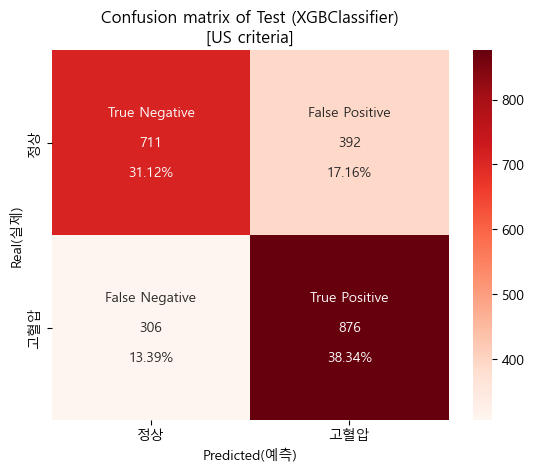

[US criteria]
Baseline accuracy(US): 0.5205209587391922
Validation accuracy(US, CV=5): 0.7275927343195132
Test accuracy(US): 0.6945295404814005


In [17]:
y_pred_test_us = xgb_us_tun.predict(X_test)
df_test_us = pd.DataFrame(data={'y_real_us':y_test_us,
                                'y_pred_us':y_pred_test_us})
table_test_us = pd.crosstab(df_test_us['y_real_us'],df_test_us['y_pred_us'])
display(table_test_us)

cfm_test_us = confusion_matrix(y_test_us,y_pred_test_us)
group_names_test_us = ['True Negative','False Positive','False Negative','True Positive']
group_counts_test_us = ['{0:0.0f}'.format(value) for value in cfm_test_us.flatten()]
group_percentages_test_us = ['{0:.2%}'.format(value) for value in cfm_test_us.flatten()/np.sum(cfm_test_us)]
labels_test_us = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_test_us,group_counts_test_us,group_percentages_test_us)]
labels_test_us = np.asarray(labels_test_us).reshape(2,2)
tick_test_us = ['정상','고혈압']
sns.heatmap(cfm_test_us, annot=labels_test_us, fmt='',cmap='Reds',xticklabels=tick_test_us,yticklabels=tick_test_us)
plt.xlabel('Predicted(예측)')
plt.ylabel('Real(실제)')
plt.title('Confusion matrix of Test (XGBClassifier)\n[US criteria]')
plt.show()

score_accuracy_test_us = accuracy_score(y_test_us,y_pred_test_us)
print('[US criteria]')
print("Baseline accuracy(US): {}".format(accuracy_score(y_train_us, baseline_us)))
print('Validation accuracy(US, CV=5): {}'.format(CV_score_accuracy_final_us.mean()))
print('Test accuracy(US): {}'.format(score_accuracy_test_us))

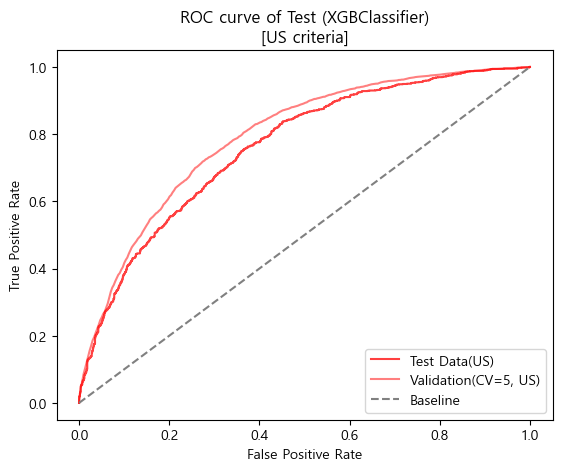

[US criteria]
Baseline AUC_score(US): 0.5
Validation AUC_score(US, CV=5): 0.794148446162498
Test AUC_score(US): 0.7608080868512732


In [18]:
y_test_prob_us = xgb_us_tun.predict_proba(X_test)[:,1]

FPR_test_us, TPR_test_us, _ = roc_curve(y_test_us,y_test_prob_us)

plt.plot(FPR_test_us,TPR_test_us,label='Test Data(US)',color='red',alpha=0.75)
plt.plot(base_fpr_final_us,mean_tprs_final_us,label='Validation(CV=5, US)',color='red',alpha=0.5)
plt.plot([0,1],[0,1], linestyle='--', label='Baseline', color = 'gray')
plt.title('ROC curve of Test (XGBClassifier)\n[US criteria]')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

score_auc_test_us = roc_auc_score(y_test_us,y_test_prob_us)
print('[US criteria]')
print("Baseline AUC_score(US): {}".format(roc_auc_score(y_train_us, baseline_us)))
print('Validation AUC_score(US, CV=5): {}'.format(CV_score_auc_final_us.mean()))
print('Test AUC_score(US): {}'.format(score_auc_test_us))

#### EU criteria

y_pred_eu,0,1
y_real_eu,,
0,1342,226
1,304,413


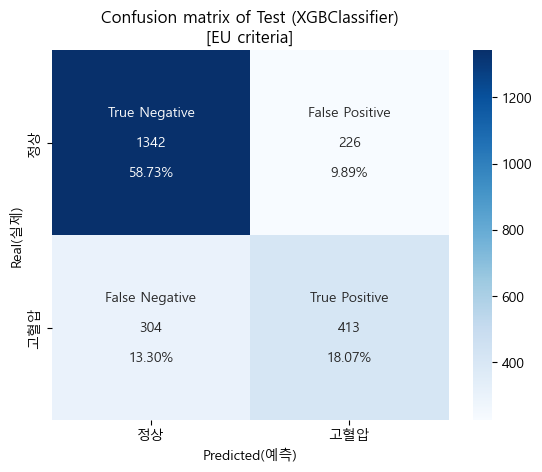

[EU criteria]
Baseline accuracy(EU): 0.6736346722118858
Validation accuracy(EU, CV=5): 0.7719166310353212
Test accuracy(EU): 0.7680525164113785


In [19]:
y_pred_test_eu = xgb_eu_tun.predict(X_test)
df_test_eu = pd.DataFrame(data={'y_real_eu':y_test_eu,
                                'y_pred_eu':y_pred_test_eu})
table_test_eu = pd.crosstab(df_test_eu['y_real_eu'],df_test_eu['y_pred_eu'])
display(table_test_eu)

cfm_test_eu = confusion_matrix(y_test_eu,y_pred_test_eu)
group_names_test_eu = ['True Negative','False Positive','False Negative','True Positive']
group_counts_test_eu = ['{0:0.0f}'.format(value) for value in cfm_test_eu.flatten()]
group_percentages_test_eu = ['{0:.2%}'.format(value) for value in cfm_test_eu.flatten()/np.sum(cfm_test_eu)]
labels_test_eu = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_test_eu,group_counts_test_eu,group_percentages_test_eu)]
labels_test_eu = np.asarray(labels_test_eu).reshape(2,2)
tick_test_eu = ['정상','고혈압']
sns.heatmap(cfm_test_eu, annot=labels_test_eu, fmt='',cmap='Blues',xticklabels=tick_test_eu,yticklabels=tick_test_eu)
plt.xlabel('Predicted(예측)')
plt.ylabel('Real(실제)')
plt.title('Confusion matrix of Test (XGBClassifier)\n[EU criteria]')
plt.show()

score_accuracy_test_eu = accuracy_score(y_test_eu,y_pred_test_eu)
print('[EU criteria]')
print("Baseline accuracy(EU): {}".format(accuracy_score(y_train_eu, baseline_eu)))
print('Validation accuracy(EU, CV=5): {}'.format(CV_score_accuracy_final_eu.mean()))
print('Test accuracy(EU): {}'.format(score_accuracy_test_eu))

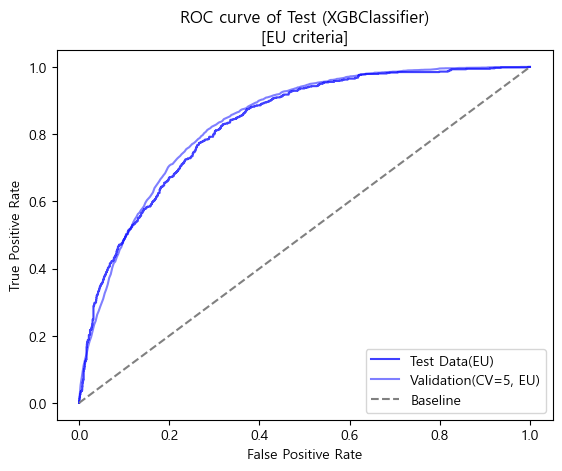

[EU criteria]
Baseline AUC_score(EU): 0.5
Validation AUC_score(EU): 0.8380314251605574
Test AUC_score(EU): 0.8300106915150998


In [20]:
y_test_prob_eu = xgb_eu_tun.predict_proba(X_test)[:,1]

FPR_test_eu, TPR_test_eu, _ = roc_curve(y_test_eu,y_test_prob_eu)

plt.plot(FPR_test_eu,TPR_test_eu,label='Test Data(EU)',color='blue',alpha=0.75)
plt.plot(base_fpr_final_eu,mean_tprs_final_eu,label='Validation(CV=5, EU)',color='blue',alpha=0.5)
plt.plot([0,1],[0,1], linestyle='--', label='Baseline', color = 'gray')
plt.title('ROC curve of Test (XGBClassifier)\n[EU criteria]')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

score_auc_test_eu = roc_auc_score(y_test_eu,y_test_prob_eu)
print('[EU criteria]')
print("Baseline AUC_score(EU): {}".format(roc_auc_score(y_train_eu, baseline_eu)))
print('Validation AUC_score(EU): {}'.format(CV_score_auc_final_eu.mean()))
print('Test AUC_score(EU): {}'.format(score_auc_test_eu))

#### US & EU

In [21]:
print('[Accuracy]\n')
print("Baseline accuracy(US): {}".format(accuracy_score(y_train_us, baseline_us)))
print('Validation accuracy(US): {}'.format(CV_score_accuracy_final_us.mean()))
print('Test accuracy(US): {}\n'.format(score_accuracy_test_us))
print("Baseline accuracy(EU): {}".format(accuracy_score(y_train_eu, baseline_eu)))
print('Validation accuracy(EU): {}'.format(CV_score_accuracy_final_eu.mean()))
print('Test accuracy(EU): {}\n'.format(score_accuracy_test_eu))


[Accuracy]

Baseline accuracy(US): 0.5205209587391922
Validation accuracy(US): 0.7275927343195132
Test accuracy(US): 0.6945295404814005

Baseline accuracy(EU): 0.6736346722118858
Validation accuracy(EU): 0.7719166310353212
Test accuracy(EU): 0.7680525164113785



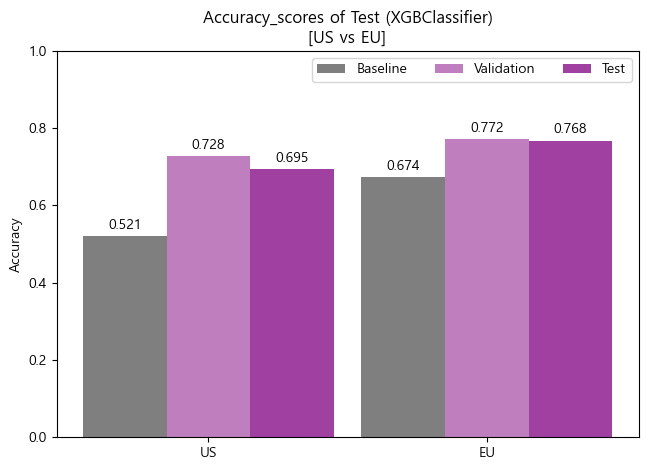

In [22]:
df_accuracy_test = pd.DataFrame({'Baseline':[accuracy_score(y_train_us, baseline_us),
                                             accuracy_score(y_train_eu, baseline_eu)],
                                 'Validation':[CV_score_accuracy_final_us.mean(),
                                               CV_score_accuracy_final_eu.mean()],
                                 'Test':[score_accuracy_test_us,
                                         score_accuracy_test_eu]},
                                index=['US','EU'])

x = np.arange(2)
width = 0.3

fig, ax = plt.subplots()
rect1 = ax.bar(x-width, df_accuracy_test.Baseline.round(3), width, label='Baseline',color='black',alpha=0.5)
rect2 = ax.bar(x, df_accuracy_test.Validation.round(3), width, label='Validation',color='purple',alpha=0.5)
rect3 = ax.bar(x+width, df_accuracy_test.Test.round(3), width, label='Test',color='purple',alpha=0.75)

ax.set_title('Accuracy_scores of Test (XGBClassifier)\n[US vs EU]')
ax.set_xticks(x, df_accuracy_test.index)
ax.bar_label(rect1, padding=3)
ax.bar_label(rect2, padding=3)
ax.bar_label(rect3, padding=3)

fig.tight_layout()

plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(ncol=3)
plt.show()

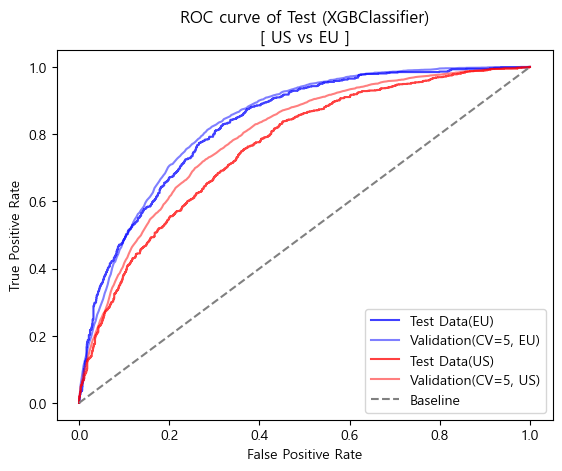

[AUC_score]
Validation AUC_score(US): 0.794148446162498
Test AUC_score(US): 0.7608080868512732
Validation AUC_score(EU): 0.8380314251605574
Test AUC_score(EU): 0.8300106915150998


In [23]:
plt.plot(FPR_test_eu,TPR_test_eu,label='Test Data(EU)',color='blue',alpha=0.75)
plt.plot(base_fpr_final_eu,mean_tprs_final_eu,label='Validation(CV=5, EU)',color='blue',alpha=0.5)
plt.plot(FPR_test_us,TPR_test_us,label='Test Data(US)',color='red',alpha=0.75)
plt.plot(base_fpr_final_us,mean_tprs_final_us,label='Validation(CV=5, US)',color='red',alpha=0.5)
plt.plot([0,1],[0,1], linestyle='--', label='Baseline', color = 'gray')
plt.title('ROC curve of Test (XGBClassifier)\n[ US vs EU ]')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
print('[AUC_score]')
print('Validation AUC_score(US): {}'.format(CV_score_auc_final_us.mean()))
print('Test AUC_score(US): {}'.format(score_auc_test_us))
print('Validation AUC_score(EU): {}'.format(CV_score_auc_final_eu.mean()))
print('Test AUC_score(EU): {}'.format(score_auc_test_eu))

## 2. Interpretation

### 2-0. Correlation

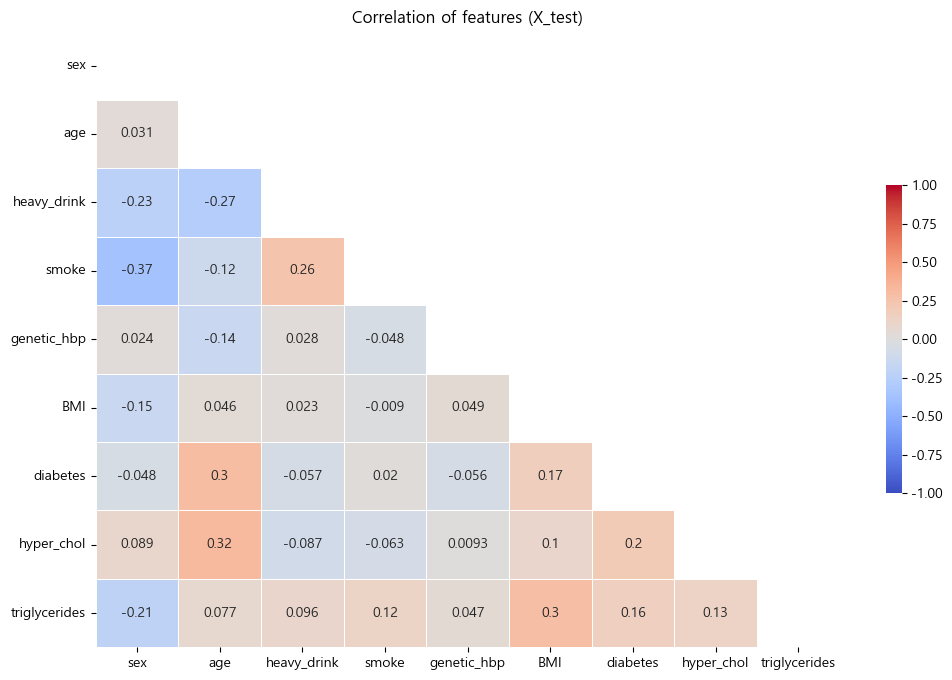

In [24]:
corr_test = X_test.corr()
fig, ax = plt.subplots(figsize=(12,8))
mask = np.zeros_like(corr_test,dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_test,
            cmap='coolwarm',
            annot=True,
            mask=mask,
            linewidths=.5,
            cbar_kws={'shrink':.5},
            vmin=-1,
            vmax=1)
plt.title('Correlation of features (X_test)')
plt.show()

### 2-1. Importance

#### Model Specific

- Feature Importance (MDI)

,FeatureImportance(US)
age,0.199682
sex,0.140304
BMI,0.134779
diabetes,0.134410
genetic_hbp,0.086920
triglycerides,0.084646
heavy_drink,0.081477
hyper_chol,0.080719
smoke,0.057063


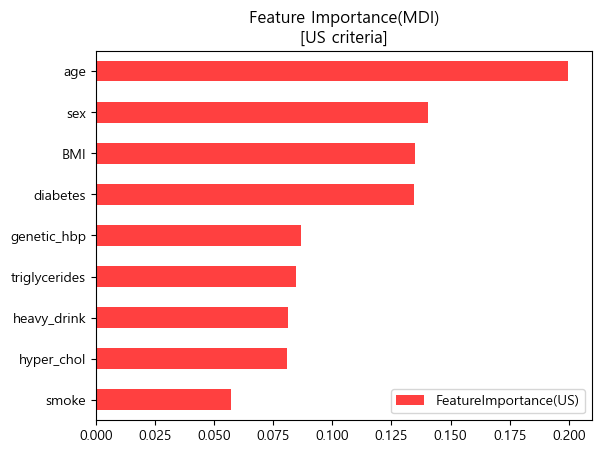

In [25]:
importances_us = pd.DataFrame(data={'FeatureImportance(US)':xgb_us_tun.feature_importances_},index=X_train.columns)

display(importances_us.sort_values(by='FeatureImportance(US)',ascending=False).style.background_gradient(cmap='Reds'))

importances_us.sort_values(by='FeatureImportance(US)').plot.barh(color='red',alpha=0.75)
plt.title('Feature Importance(MDI)\n[US criteria]')
plt.legend(loc='lower right')
plt.show()

,FeatureImportance(EU)
age,0.272672
diabetes,0.182110
hyper_chol,0.128000
BMI,0.114558
genetic_hbp,0.080709
heavy_drink,0.072911
triglycerides,0.052503
sex,0.051182
smoke,0.045355


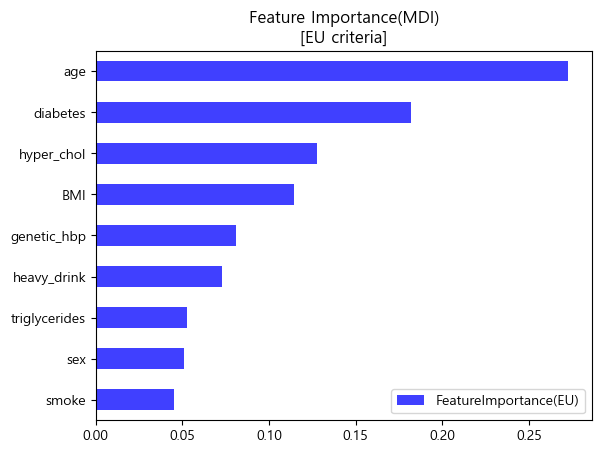

In [26]:
importances_eu = pd.DataFrame(data={'FeatureImportance(EU)':xgb_eu_tun.feature_importances_},index=X_train.columns)

display(importances_eu.sort_values(by='FeatureImportance(EU)',ascending=False).style.background_gradient(cmap='Blues'))

importances_eu.sort_values(by='FeatureImportance(EU)').plot.barh(color='blue',alpha=0.75)
plt.title('Feature Importance(MDI)\n[EU criteria]')
plt.legend(loc='lower right')
plt.show()

#### Model Agnostic

- Permutation Importance

In [27]:
permuter_us = PermutationImportance(
    xgb_us_tun,
    scoring='roc_auc',
    n_iter=10,
    random_state=42
)

permuter_us.fit(X_test,y_test_us)

PermutationImportance(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=0.8,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc', gamma=0,
                                              gpu_id=-1,
                                              grow_policy='depthwise',
                                              importance_type=None,
                                              interaction_constraints='',
                                              learning_rate=0.05, max_bin=256,
                                              max_cat_to_onehot=4,
                                              max_delta_step=0, max_depth=2,
                                              max_leaves=0, min_child_weight=4,
                                              missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=200, n_jobs=-1,
                                              num_parallel_tree=1,
                                              predictor='auto', random_state=42,
                                              reg_alpha=0, reg_lambda=1, ...),
                      n_iter=10, random_state=42, scoring='roc_auc')

Weight,Feature
0.1621 ± 0.0157,age
0.0515 ± 0.0118,BMI
0.0096 ± 0.0025,genetic_hbp
0.0091 ± 0.0025,sex
0.0052 ± 0.0038,heavy_drink
0.0037 ± 0.0013,hyper_chol
0.0033 ± 0.0035,triglycerides
0.0016 ± 0.0015,diabetes
0.0003 ± 0.0011,smoke


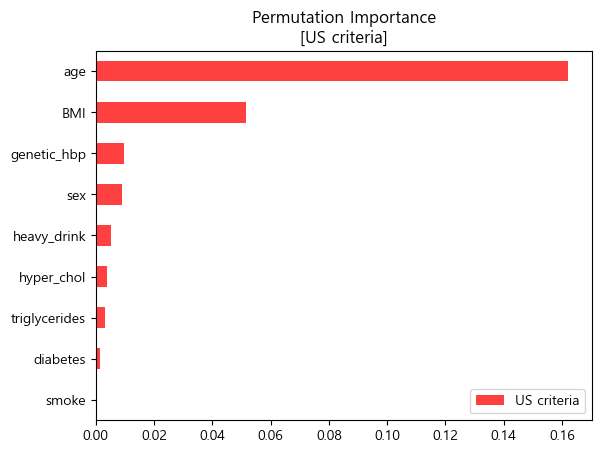

In [28]:
features_us = X_test.columns.to_list()

display(
    eli5.show_weights(
    permuter_us,
    top=None,
    feature_names=features_us
))

pi_us = pd.Series(permuter_us.feature_importances_,features_us).sort_values()
pi_us.plot.barh(color='red',alpha=0.75,label='US criteria')
plt.legend(loc='lower right')
plt.title('Permutation Importance\n[US criteria]')
plt.show()

In [29]:
permuter_eu = PermutationImportance(
    xgb_eu_tun,
    scoring='roc_auc',
    n_iter=10,
    random_state=42
)

permuter_eu.fit(X_test,y_test_eu)

PermutationImportance(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=0.9,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc', gamma=0,
                                              gpu_id=-1,
                                              grow_policy='depthwise',
                                              importance_type=None,
                                              interaction_constraints='',
                                              learning_rate=0.05, max_bin=256,
                                              max_cat_to_onehot=4,
                                              max_delta_step=0, max_depth=2,
                                              max_leaves=0, min_child_weight=8,
                                              missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=200, n_jobs=-1,
                                              num_parallel_tree=1,
                                              predictor='auto', random_state=42,
                                              reg_alpha=0, reg_lambda=1, ...),
                      n_iter=10, random_state=42, scoring='roc_auc')

Weight,Feature
0.2597 ± 0.0209,age
0.0322 ± 0.0057,BMI
0.0119 ± 0.0036,genetic_hbp
0.0086 ± 0.0017,hyper_chol
0.0053 ± 0.0028,heavy_drink
0.0041 ± 0.0021,diabetes
0.0032 ± 0.0009,sex
0.0026 ± 0.0019,triglycerides
0.0003 ± 0.0003,smoke


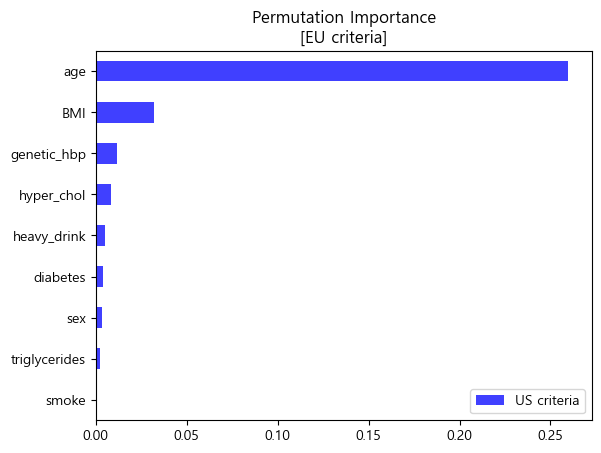

In [30]:
features_eu = X_test.columns.to_list()

display(
    eli5.show_weights(
    permuter_eu,
    top=None,
    feature_names=features_eu
))

pi_eu = pd.Series(permuter_eu.feature_importances_,features_eu).sort_values()
pi_eu.plot.barh(color='blue',alpha=0.75,label='US criteria')
plt.legend(loc='lower right')
plt.title('Permutation Importance\n[EU criteria]')
plt.show()

### 2-2. Features

#### 조절 불가 요인

- Age [연속형변수]

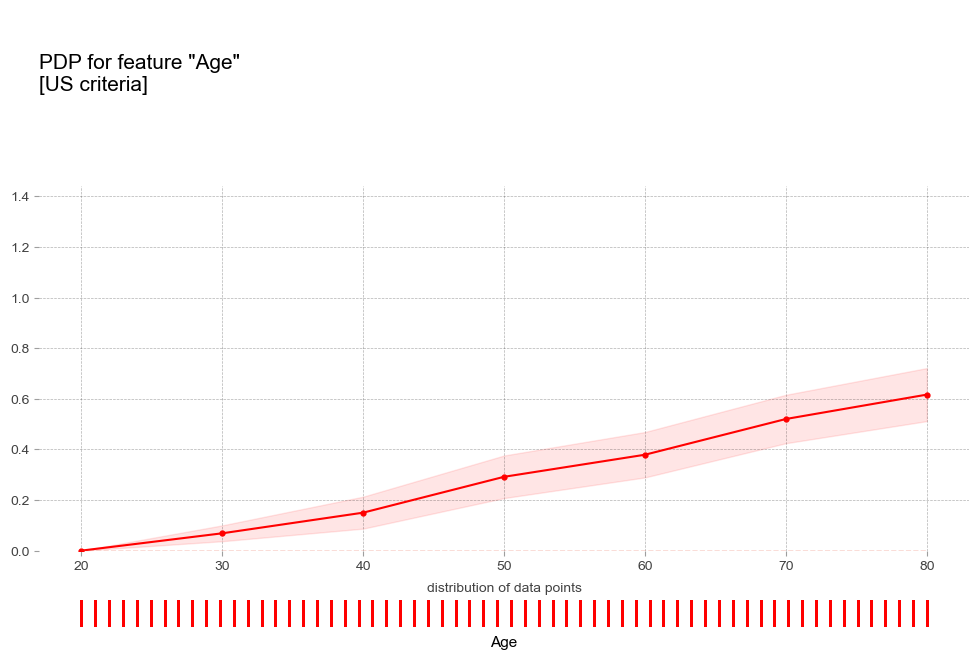

In [31]:
pdp_age_us = pdp_isolate(
    model=xgb_us_tun,
    dataset=X_test,
    model_features=X_test.columns,
    feature='age',
    grid_type='percentile',
    cust_grid_points=[20,30,40,50,60,70,80]
)
pdp_plot(pdp_age_us,
         'Age',
         plot_pts_dist=True,
         figsize=(12,8),
         plot_params={
             'title':'PDP for feature "Age"\n[US criteria]',
             'subtitle':'',
             'fill_color':'red',
             'fill_alpha':0.1,
             'pdp_color':'red'
         })
plt.show()

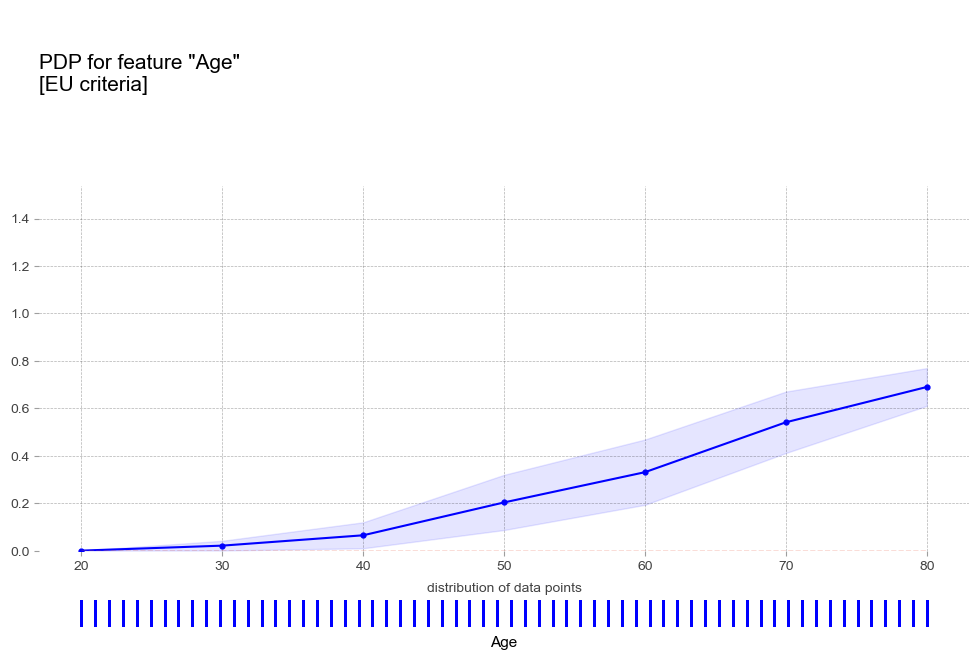

In [32]:
pdp_age_eu = pdp_isolate(
    model=xgb_eu_tun,
    dataset=X_test,
    model_features=X_test.columns,
    feature='age',
    grid_type='percentile',
    cust_grid_points=[20,30,40,50,60,70,80]
)
pdp_plot(pdp_age_eu,
         'Age',
         plot_pts_dist=True,
         figsize=(12,8),
         plot_params={
             'title':'PDP for feature "Age"\n[EU criteria]',
             'subtitle':'',
             'fill_color':'blue',
             'fill_alpha':0.1,
             'pdp_color':'blue'
         })
plt.show()

- Sex

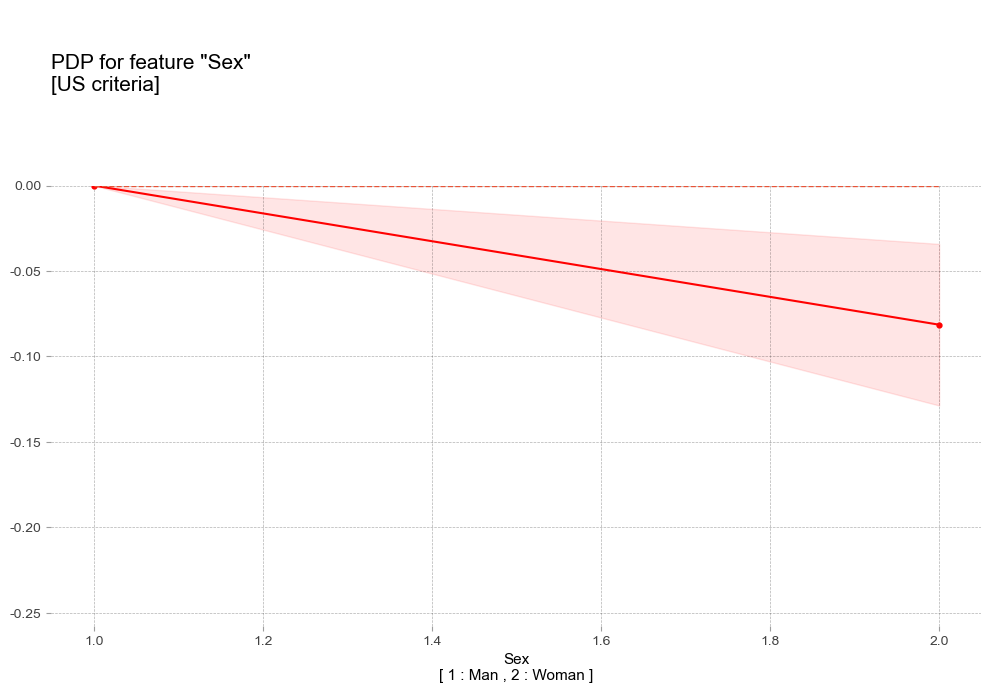

In [33]:
pdp_sex_us = pdp_isolate(
    model=xgb_us_tun,
    dataset=X_test,
    model_features=X_test.columns,
    feature='sex',
    grid_type='percentile',
    cust_grid_points=[1,2]    
)
pdp_plot(pdp_sex_us,
         'Sex\n[ 1 : Man , 2 : Woman ]',
         figsize=(12,8),
         plot_params={
             'title':'PDP for feature "Sex"\n[US criteria]',
             'subtitle':'',
             'fill_color':'red',
             'fill_alpha':0.1,
             'pdp_color':'red'
         })
plt.show()

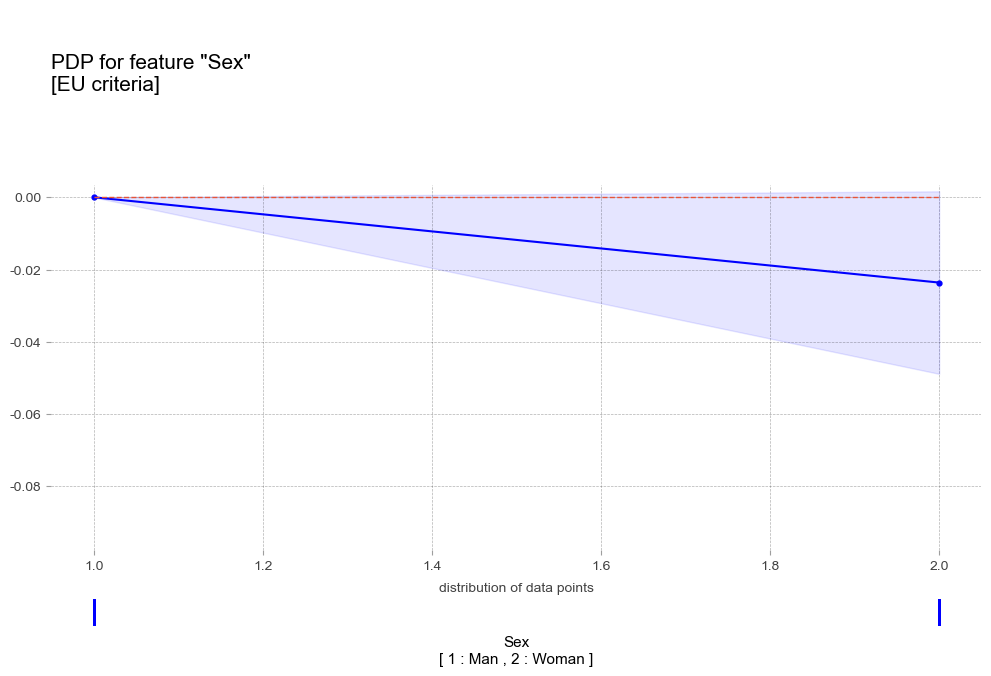

In [34]:
pdp_sex_eu = pdp_isolate(
    model=xgb_eu_tun,
    dataset=X_test,
    model_features=X_test.columns,
    feature='sex',
    grid_type='percentile',
    cust_grid_points=[1,2]
)
pdp_plot(pdp_sex_eu,
         'Sex\n[ 1 : Man , 2 : Woman ]',
         plot_pts_dist=True,
         figsize=(12,8),
         plot_params={
             'title':'PDP for feature "Sex"\n[EU criteria]',
             'subtitle':'',
             'fill_color':'blue',
             'fill_alpha':0.1,
             'pdp_color':'blue'
         })
plt.show()

- Age & Sex

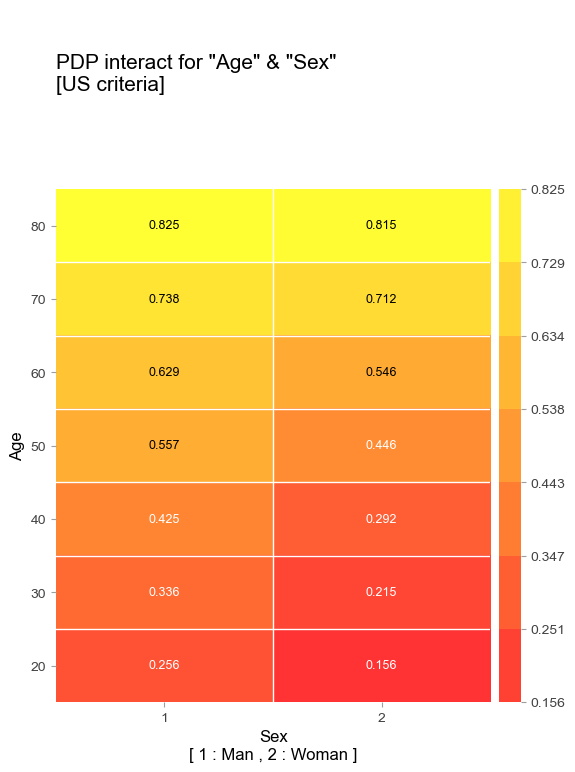

In [35]:
age_sex = ['sex','age']
pdp_age_sex_us = pdp_interact(
    model=xgb_us_tun,
    dataset=X_test,
    model_features=X_test.columns,
    features=age_sex,
    grid_types=['percentile','percentile'],
    cust_grid_points=[[1,2],
                      [20,30,40,50,60,70,80]]
)
pdp_interact_plot(
    pdp_age_sex_us,
    figsize=(6,9),
    plot_type='grid',
    feature_names=['Sex\n[ 1 : Man , 2 : Woman ]','Age'],
    plot_params={
        'title':'PDP interact for "Age" & "Sex"\n[US criteria]',
        'subtitle':'',
        'cmap':'autumn',
    })
plt.show()

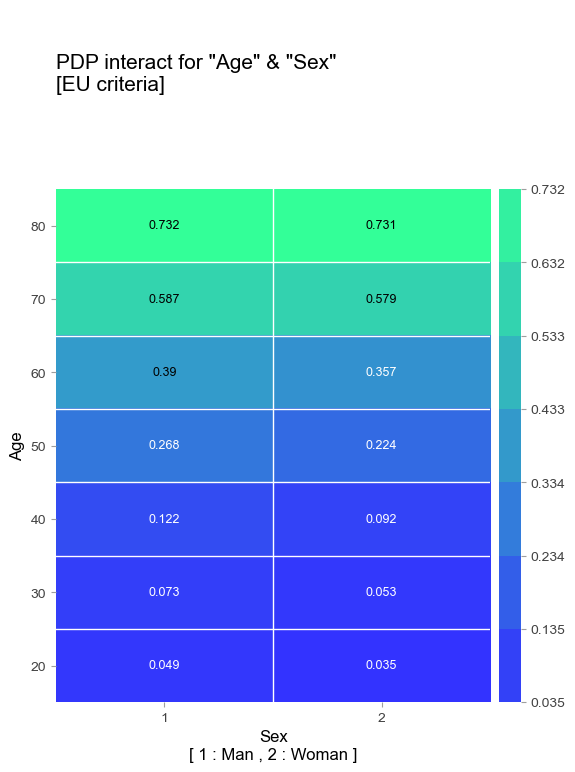

In [36]:
age_sex = ['sex','age']
pdp_age_sex_eu = pdp_interact(
    model=xgb_eu_tun,
    dataset=X_test,
    model_features=X_test.columns,
    features=age_sex,
    grid_types=['percentile','percentile'],
    cust_grid_points=[[1,2],
                      [20,30,40,50,60,70,80]]
)
pdp_interact_plot(
    pdp_age_sex_eu,
    figsize=(6,9),
    plot_type='grid',
    feature_names=['Sex\n[ 1 : Man , 2 : Woman ]','Age'],
    plot_params={
        'title':'PDP interact for "Age" & "Sex"\n[EU criteria]',
        'subtitle':'',
        'cmap':'winter',
    })
plt.show()

- Genetic(HBP)

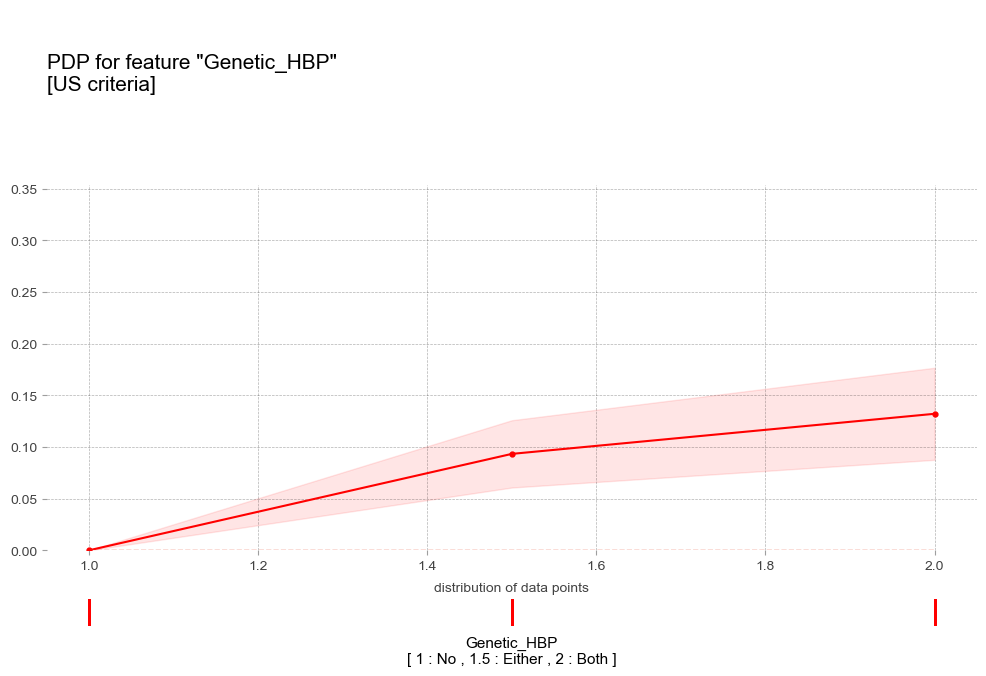

In [37]:
pdp_gen_us = pdp_isolate(
    model=xgb_us_tun,
    dataset=X_test,
    model_features=X_test.columns,
    feature='genetic_hbp',
    grid_type='percentile',
    cust_grid_points=[1,1.5,2]    
)
pdp_plot(pdp_gen_us,
         'Genetic_HBP\n[ 1 : No , 1.5 : Either , 2 : Both ]',
         plot_pts_dist=True,
         figsize=(12,8),
         plot_params={
             'title':'PDP for feature "Genetic_HBP"\n[US criteria]',
             'subtitle':'',
             'fill_color':'red',
             'fill_alpha':0.1,
             'pdp_color':'red'
         })
plt.show()

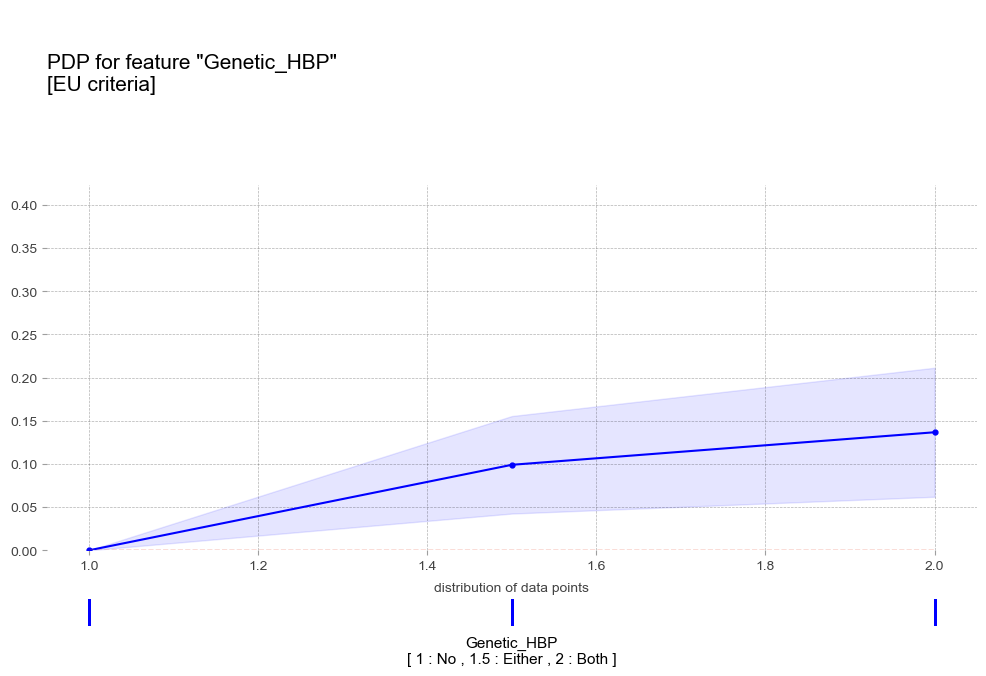

In [38]:
pdp_gen_eu = pdp_isolate(
    model=xgb_eu_tun,
    dataset=X_test,
    model_features=X_test.columns,
    feature='genetic_hbp',
    grid_type='percentile',
    cust_grid_points=[1,1.5,2]
)
pdp_plot(pdp_gen_eu,
         'Genetic_HBP\n[ 1 : No , 1.5 : Either , 2 : Both ]',
         plot_pts_dist=True,
         figsize=(12,8),
         plot_params={
             'title':'PDP for feature "Genetic_HBP"\n[EU criteria]',
             'subtitle':'',
             'fill_color':'blue',
             'fill_alpha':0.1,
             'pdp_color':'blue'
         })
plt.show()

- Age & Genetic(HBP)

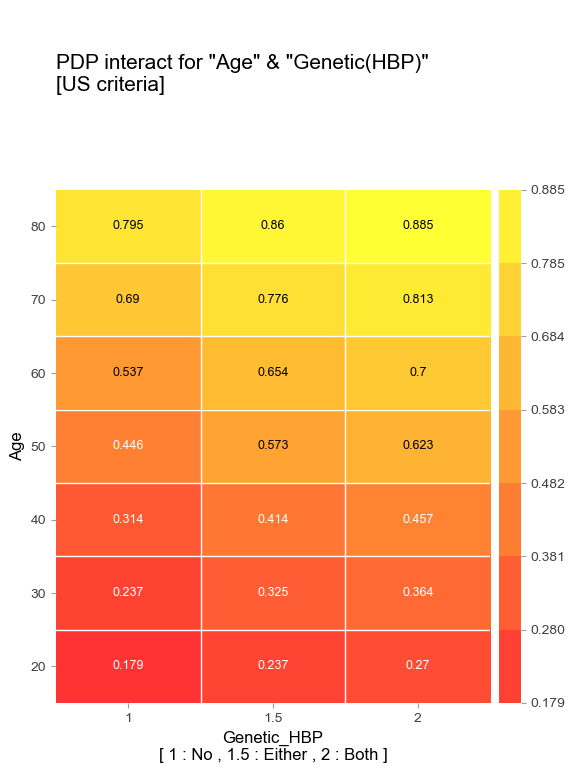

In [39]:
age_gen = ['genetic_hbp','age']
pdp_age_gen_us = pdp_interact(
    model=xgb_us_tun,
    dataset=X_test,
    model_features=X_test.columns,
    features=age_gen,
    grid_types=['percentile','percentile'],
    cust_grid_points=[[1,1.5,2],
                      [20,30,40,50,60,70,80]]
)
pdp_interact_plot(
    pdp_age_gen_us,
    figsize=(6,9),
    plot_type='grid',
    feature_names=['Genetic_HBP\n[ 1 : No , 1.5 : Either , 2 : Both ]','Age'],
    plot_params={
        'title':'PDP interact for "Age" & "Genetic(HBP)"\n[US criteria]',
        'subtitle':'',
        'cmap':'autumn',
    })
plt.show()

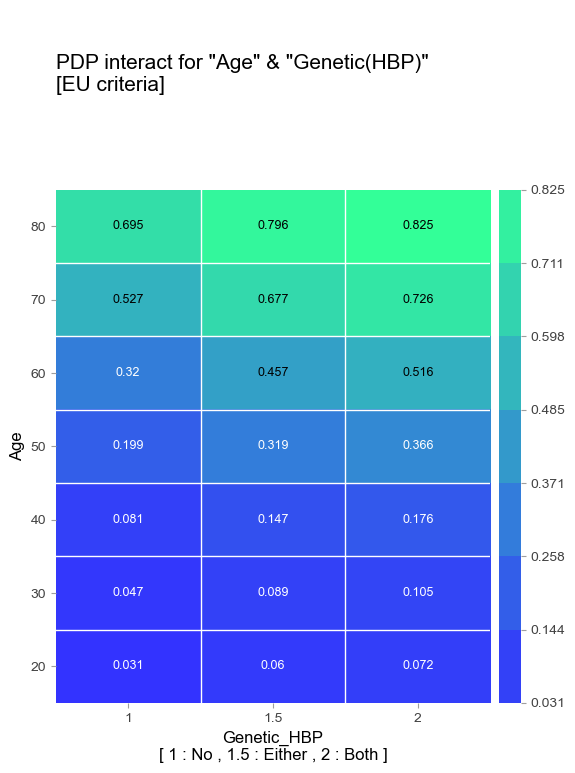

In [40]:
age_gen = ['genetic_hbp','age']
pdp_age_gen_eu = pdp_interact(
    model=xgb_eu_tun,
    dataset=X_test,
    model_features=X_test.columns,
    features=age_gen,
    grid_types=['percentile','percentile'],
    cust_grid_points=[[1,1.5,2],
                      [20,30,40,50,60,70,80]]
)
pdp_interact_plot(
    pdp_age_gen_eu,
    figsize=(6,9),
    plot_type='grid',
    feature_names=['Genetic_HBP\n[ 1 : No , 1.5 : Either , 2 : Both ]','Age'],
    plot_params={
        'title':'PDP interact for "Age" & "Genetic(HBP)"\n[EU criteria]',
        'subtitle':'',
        'cmap':'winter',
    })
plt.show()

#### 만성질환 요인

- Triglycerides [연속형변수]

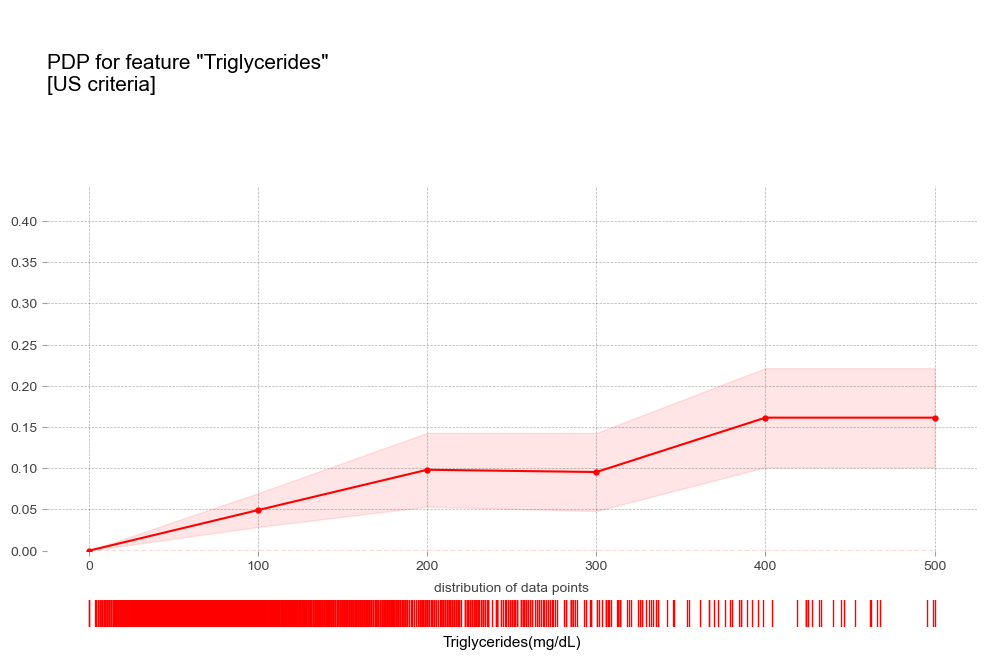

In [41]:
pdp_tg_us = pdp_isolate(
    model=xgb_us_tun,
    dataset=X_test,
    model_features=X_test.columns,
    feature='triglycerides',
    grid_type='percentile',
    cust_grid_points=[0,100,200,300,400,500]
)
pdp_plot(pdp_tg_us,
         'Triglycerides(mg/dL)',
         plot_pts_dist=True,
         figsize=(12,8),
         plot_params={
             'title':'PDP for feature "Triglycerides"\n[US criteria]',
             'subtitle':'',
             'fill_color':'red',
             'fill_alpha':0.1,
             'pdp_color':'red'
         })
plt.show()

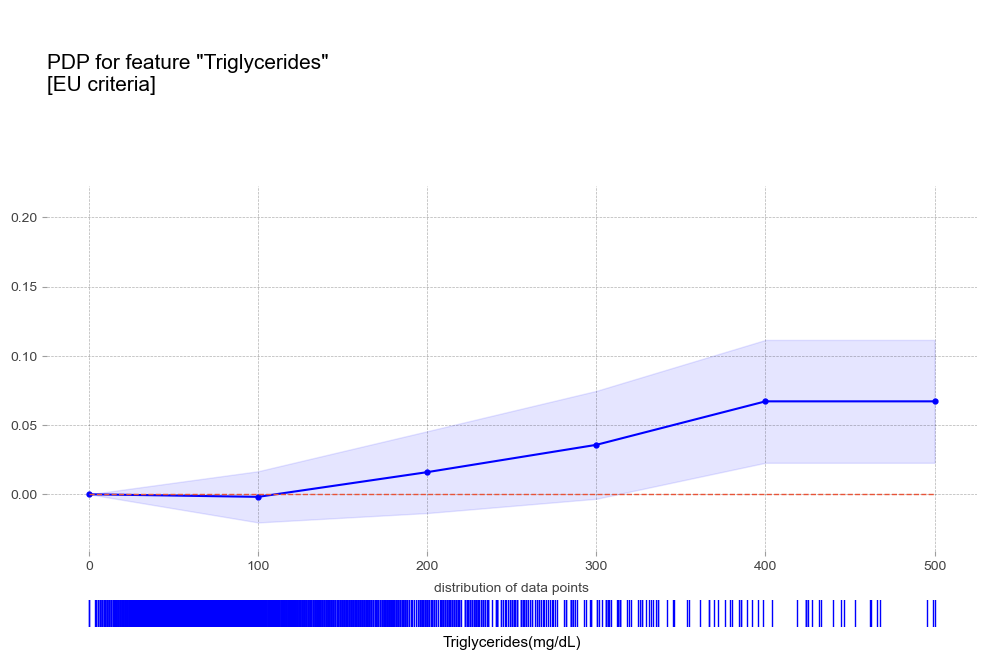

In [42]:
pdp_tg_eu = pdp_isolate(
    model=xgb_eu_tun,
    dataset=X_test,
    model_features=X_test.columns,
    feature='triglycerides',
    grid_type='percentile',
    cust_grid_points=[0,100,200,300,400,500]
)
pdp_plot(pdp_tg_eu,
         'Triglycerides(mg/dL)',
         plot_pts_dist=True,
         figsize=(12,8),
         plot_params={
             'title':'PDP for feature "Triglycerides"\n[EU criteria]',
             'subtitle':'',
             'fill_color':'blue',
             'fill_alpha':0.1,
             'pdp_color':'blue'
         })
plt.show()

- Diabetes

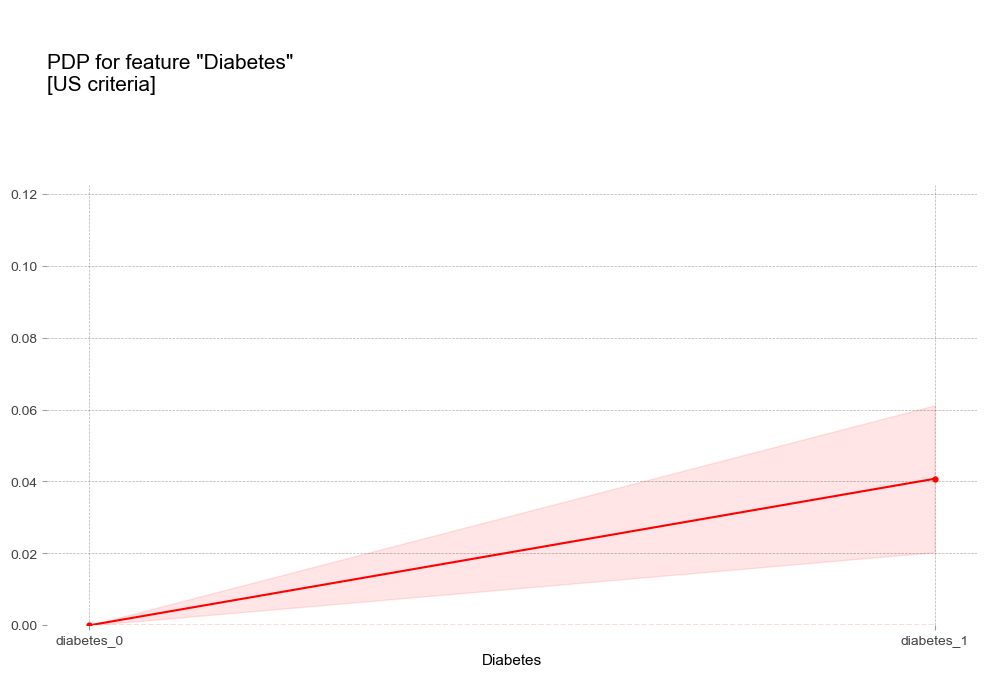

In [43]:
pdp_diab_us = pdp_isolate(
    model=xgb_us_tun,
    dataset=X_test,
    model_features=X_test.columns,
    feature='diabetes',
    grid_type='percentile',
    cust_grid_points=[0,1]
)
pdp_plot(pdp_diab_us,
         'Diabetes',
         figsize=(12,8),
         plot_params={
             'title':'PDP for feature "Diabetes"\n[US criteria]',
             'subtitle':'',
             'fill_color':'red',
             'fill_alpha':0.1,
             'pdp_color':'red'
         })
plt.show()

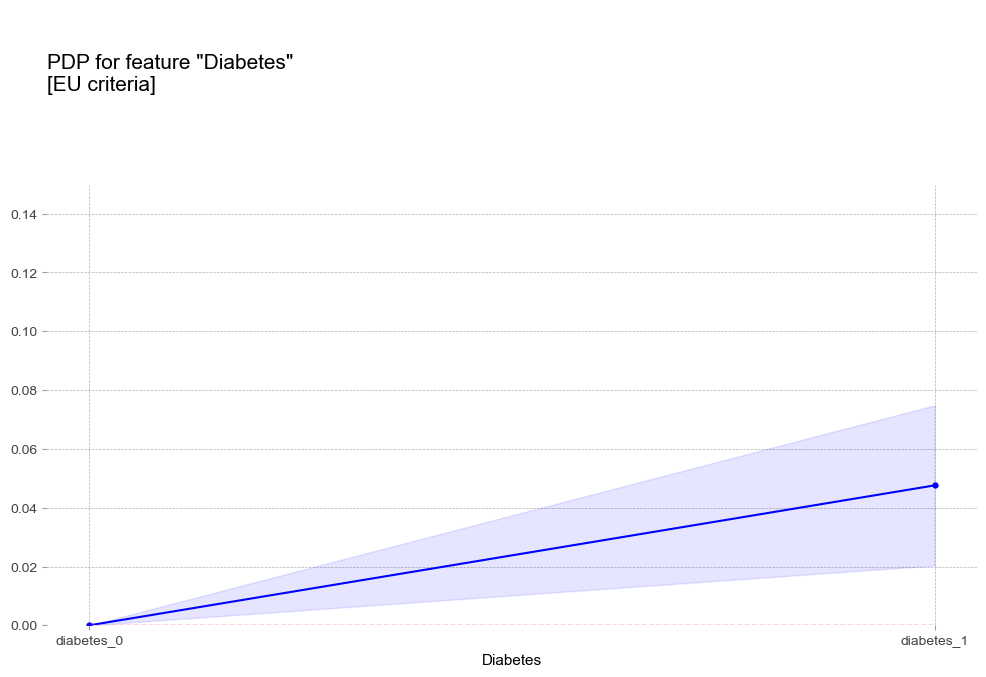

In [44]:
pdp_diab_eu = pdp_isolate(
    model=xgb_eu_tun,
    dataset=X_test,
    model_features=X_test.columns,
    feature='diabetes',
    grid_type='percentile',
    cust_grid_points=[0,1]
)
pdp_plot(pdp_diab_eu,
         'Diabetes',
         figsize=(12,8),
         plot_params={
             'title':'PDP for feature "Diabetes"\n[EU criteria]',
             'subtitle':'',
             'fill_color':'blue',
             'fill_alpha':0.1,
             'pdp_color':'blue'
         })
plt.show()

- Triglycerides & Diabetes

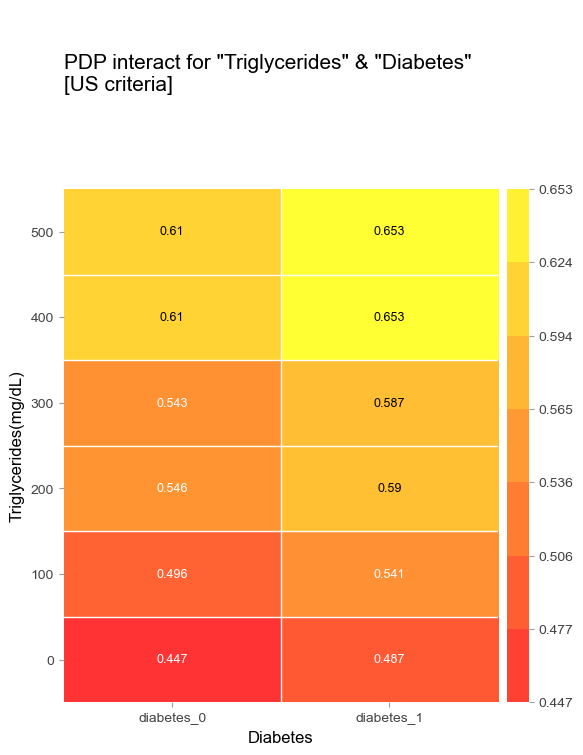

In [45]:
tg_dia = ['diabetes','triglycerides']
pdp_tg_dia_us = pdp_interact(
    model=xgb_us_tun,
    dataset=X_test,
    model_features=X_test.columns,
    features=tg_dia,
    grid_types=['percentile','percentile'],
    cust_grid_points=[[0,1],
                      [0,100,200,300,400,500]]
)
pdp_interact_plot(
    pdp_tg_dia_us,
    figsize=(6,9),
    plot_type='grid',
    feature_names=['Diabetes','Triglycerides(mg/dL)'],
    plot_params={
        'title':'PDP interact for "Triglycerides" & "Diabetes"\n[US criteria]',
        'subtitle':'',
        'cmap':'autumn',
    })
plt.show()

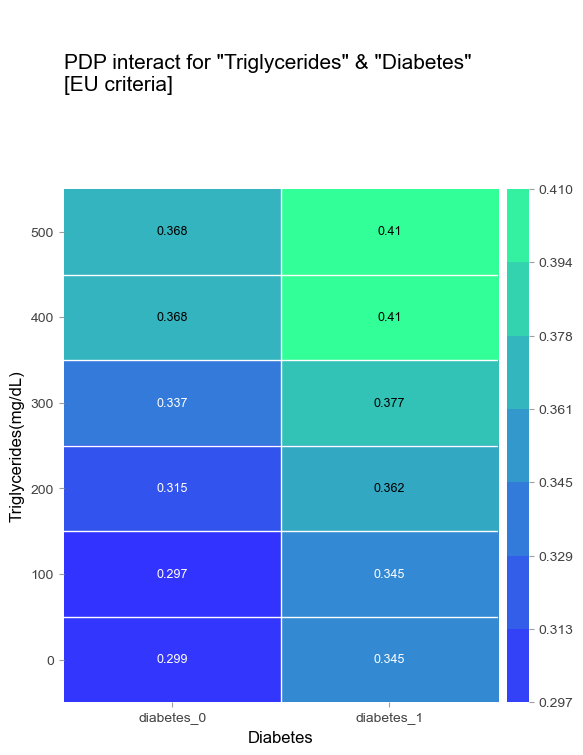

In [46]:
tg_dia = ['diabetes','triglycerides']
pdp_tg_dia_eu = pdp_interact(
    model=xgb_eu_tun,
    dataset=X_test,
    model_features=X_test.columns,
    features=tg_dia,
    grid_types=['percentile','percentile'],
    cust_grid_points=[[0,1],
                      [0,100,200,300,400,500]]
)
pdp_interact_plot(
    pdp_tg_dia_eu,
    figsize=(6,9),
    plot_type='grid',
    feature_names=['Diabetes','Triglycerides(mg/dL)'],
    plot_params={
        'title':'PDP interact for "Triglycerides" & "Diabetes"\n[EU criteria]',
        'subtitle':'',
        'cmap':'winter',
    })
plt.show()

- Hypercholesterolemia

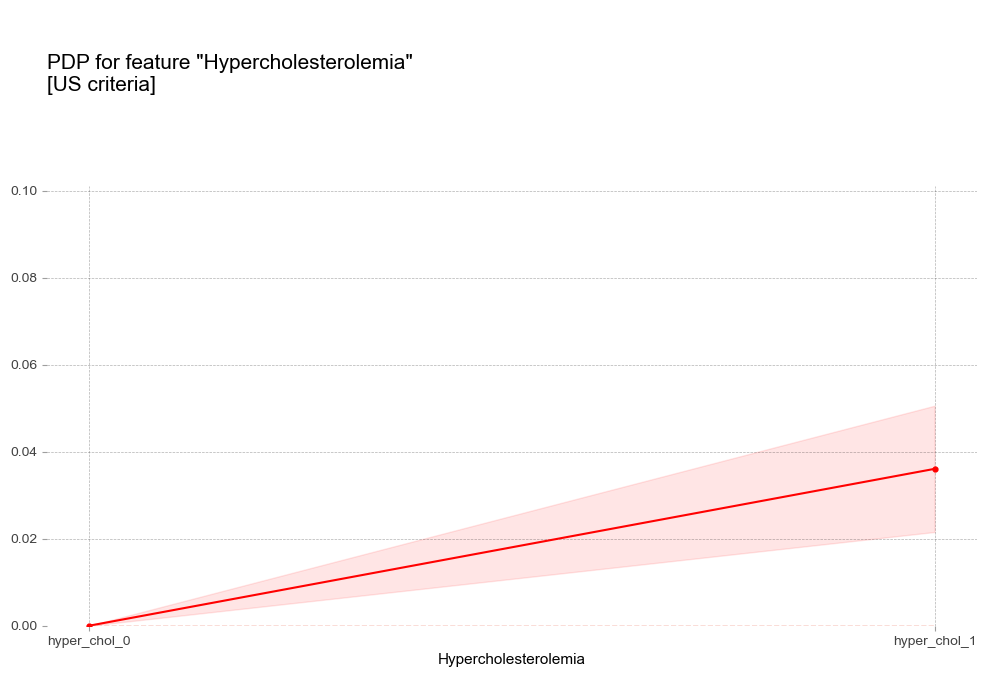

In [47]:
pdp_hc_us = pdp_isolate(
    model=xgb_us_tun,
    dataset=X_test,
    model_features=X_test.columns,
    feature='hyper_chol',
    grid_type='percentile',
    cust_grid_points=[0,1]
)
pdp_plot(pdp_hc_us,
         'Hypercholesterolemia',
         figsize=(12,8),
         plot_params={
             'title':'PDP for feature "Hypercholesterolemia"\n[US criteria]',
             'subtitle':'',
             'fill_color':'red',
             'fill_alpha':0.1,
             'pdp_color':'red'
         })
plt.show()

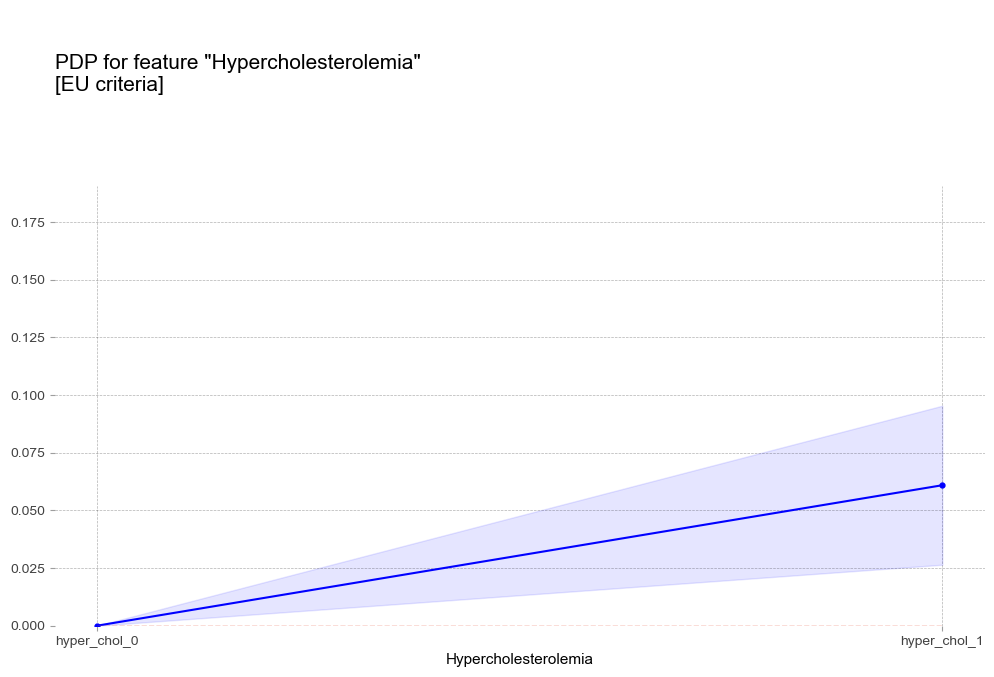

In [48]:
pdp_hc_eu = pdp_isolate(
    model=xgb_eu_tun,
    dataset=X_test,
    model_features=X_test.columns,
    feature='hyper_chol',
    grid_type='percentile',
    cust_grid_points=[0,1]
)
pdp_plot(pdp_hc_eu,
         'Hypercholesterolemia',
         figsize=(12,8),
         plot_params={
             'title':'PDP for feature "Hypercholesterolemia"\n[EU criteria]',
             'subtitle':'',
             'fill_color':'blue',
             'fill_alpha':0.1,
             'pdp_color':'blue'
         })
plt.show()

- Triglycerides & Hypercholesterolemia

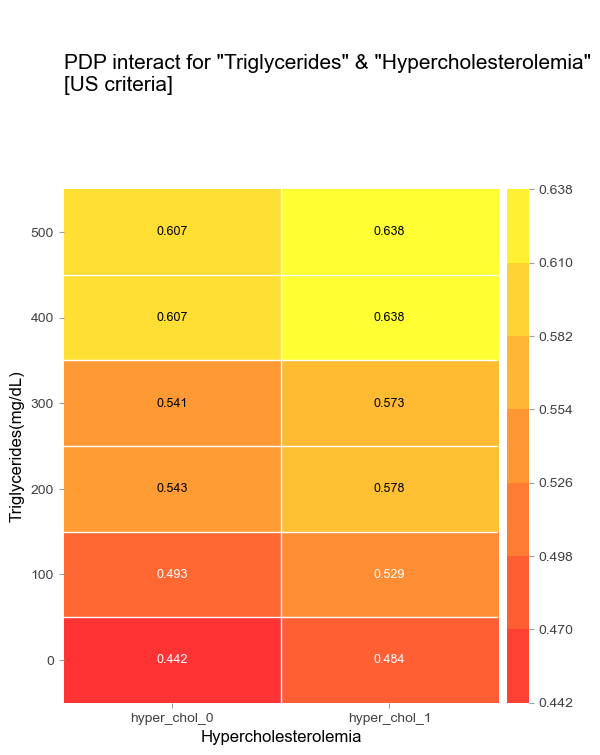

In [49]:
tg_hc = ['hyper_chol','triglycerides']
pdp_tg_hc_us = pdp_interact(
    model=xgb_us_tun,
    dataset=X_test,
    model_features=X_test.columns,
    features=tg_hc,
    grid_types=['percentile','percentile'],
    cust_grid_points=[[0,1],
                      [0,100,200,300,400,500]]
)
pdp_interact_plot(
    pdp_tg_hc_us,
    figsize=(6,9),
    plot_type='grid',
    feature_names=['Hypercholesterolemia','Triglycerides(mg/dL)'],
    plot_params={
        'title':'PDP interact for "Triglycerides" & "Hypercholesterolemia"\n[US criteria]',
        'subtitle':'',
        'cmap':'autumn',
    })
plt.show()

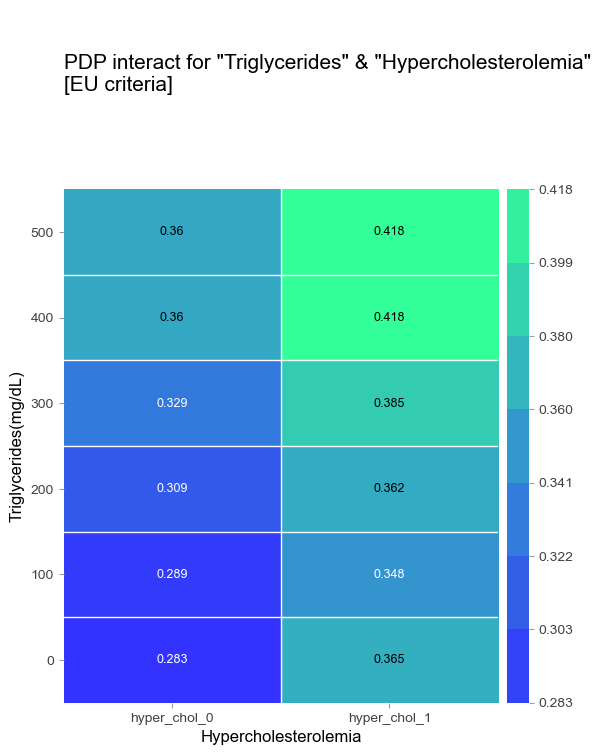

In [50]:
tg_hc = ['hyper_chol','triglycerides']
pdp_tg_hc_eu = pdp_interact(
    model=xgb_eu_tun,
    dataset=X_test,
    model_features=X_test.columns,
    features=tg_hc,
    grid_types=['percentile','percentile'],
    cust_grid_points=[[0,1],
                      [0,100,200,300,400,500]]
)
pdp_interact_plot(
    pdp_tg_hc_eu,
    figsize=(6,9),
    plot_type='grid',
    feature_names=['Hypercholesterolemia','Triglycerides(mg/dL)'],
    plot_params={
        'title':'PDP interact for "Triglycerides" & "Hypercholesterolemia"\n[EU criteria]',
        'subtitle':'',
        'cmap':'winter',
    })
plt.show()

#### 생활습관 요인

- BMI(Body Mass Index) [연속형변수]

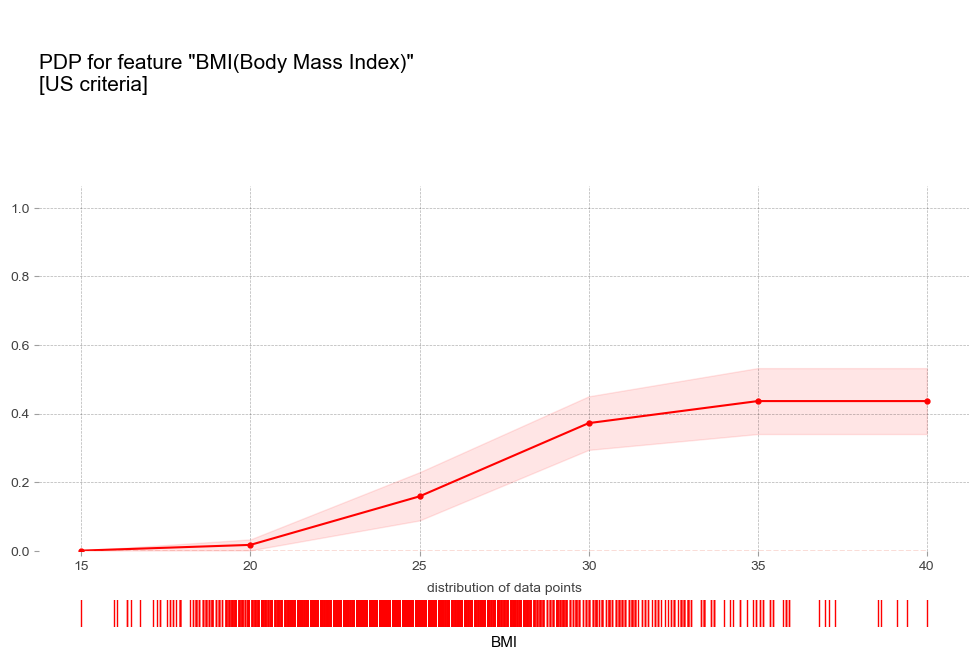

In [51]:
pdp_bmi_us = pdp_isolate(
    model=xgb_us_tun,
    dataset=X_test,
    model_features=X_test.columns,
    feature='BMI',
    grid_type='percentile',
    cust_grid_points=[15,20,25,30,35,40]
)
pdp_plot(pdp_bmi_us,
         'BMI',
         plot_pts_dist=True,
         figsize=(12,8),
         plot_params={
             'title':'PDP for feature "BMI(Body Mass Index)"\n[US criteria]',
             'subtitle':'',
             'fill_color':'red',
             'fill_alpha':0.1,
             'pdp_color':'red'
         })
plt.show()

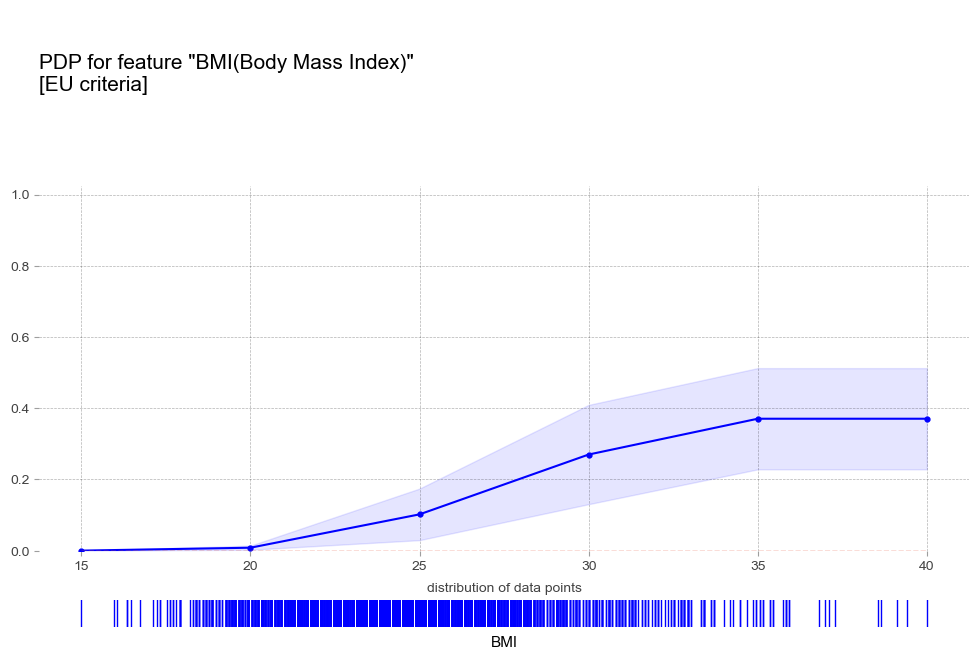

In [52]:
pdp_bmi_eu = pdp_isolate(
    model=xgb_eu_tun,
    dataset=X_test,
    model_features=X_test.columns,
    feature='BMI',
    grid_type='percentile',
    cust_grid_points=[15,20,25,30,35,40]
)
pdp_plot(pdp_bmi_eu,
         'BMI',
         plot_pts_dist=True,
         figsize=(12,8),
         plot_params={
             'title':'PDP for feature "BMI(Body Mass Index)"\n[EU criteria]',
             'subtitle':'',
             'fill_color':'blue',
             'fill_alpha':0.1,
             'pdp_color':'blue'
         })
plt.show()

- Heavy Drink

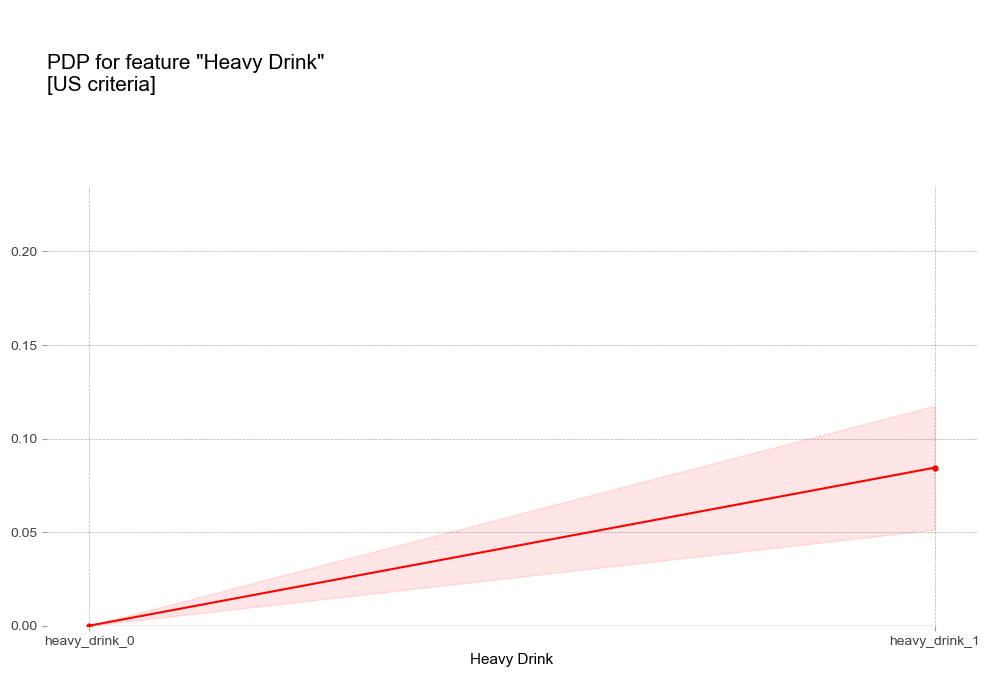

In [53]:
pdp_hd_us = pdp_isolate(
    model=xgb_us_tun,
    dataset=X_test,
    model_features=X_test.columns,
    feature='heavy_drink',
    grid_type='percentile',
    cust_grid_points=[0,1]
)
pdp_plot(pdp_hd_us,
         'Heavy Drink',
         figsize=(12,8),
         plot_params={
             'title':'PDP for feature "Heavy Drink"\n[US criteria]',
             'subtitle':'',
             'fill_color':'red',
             'fill_alpha':0.1,
             'pdp_color':'red'
         })
plt.show()

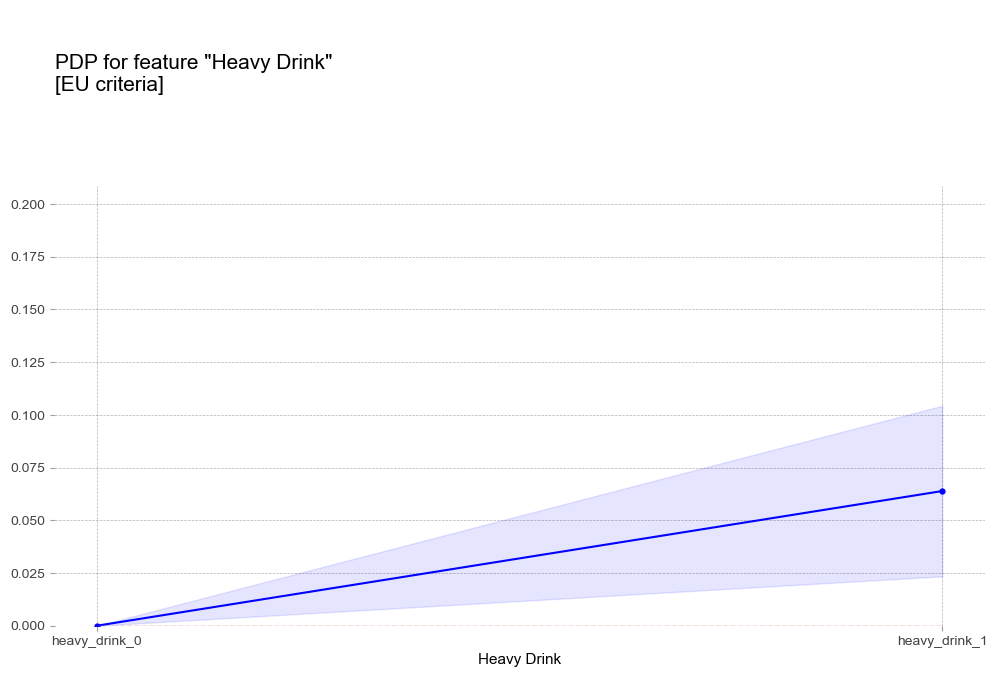

In [54]:
pdp_hd_eu = pdp_isolate(
    model=xgb_eu_tun,
    dataset=X_test,
    model_features=X_test.columns,
    feature='heavy_drink',
    grid_type='percentile',
    cust_grid_points=[0,1]
)
pdp_plot(pdp_hd_eu,
         'Heavy Drink',
         figsize=(12,8),
         plot_params={
             'title':'PDP for feature "Heavy Drink"\n[EU criteria]',
             'subtitle':'',
             'fill_color':'blue',
             'fill_alpha':0.1,
             'pdp_color':'blue'
         })
plt.show()

- BMI & Heavy Drink

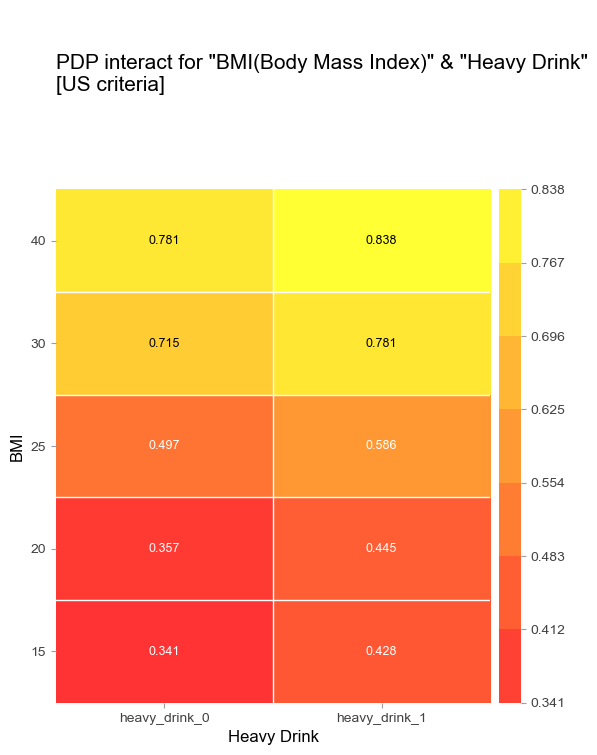

In [55]:
bmi_drink = ['heavy_drink','BMI']
pdp_bmi_drink_us = pdp_interact(
    model=xgb_us_tun,
    dataset=X_test,
    model_features=X_test.columns,
    features=bmi_drink,
    grid_types=['percentile','percentile'],
    cust_grid_points=[[0,1],
                      [15,20,25,30,40]]
)
pdp_interact_plot(
    pdp_bmi_drink_us,
    figsize=(6,9),
    plot_type='grid',
    feature_names=['Heavy Drink','BMI'],
    plot_params={
        'title':'PDP interact for "BMI(Body Mass Index)" & "Heavy Drink"\n[US criteria]',
        'subtitle':'',
        'cmap':'autumn',
    })
plt.show()

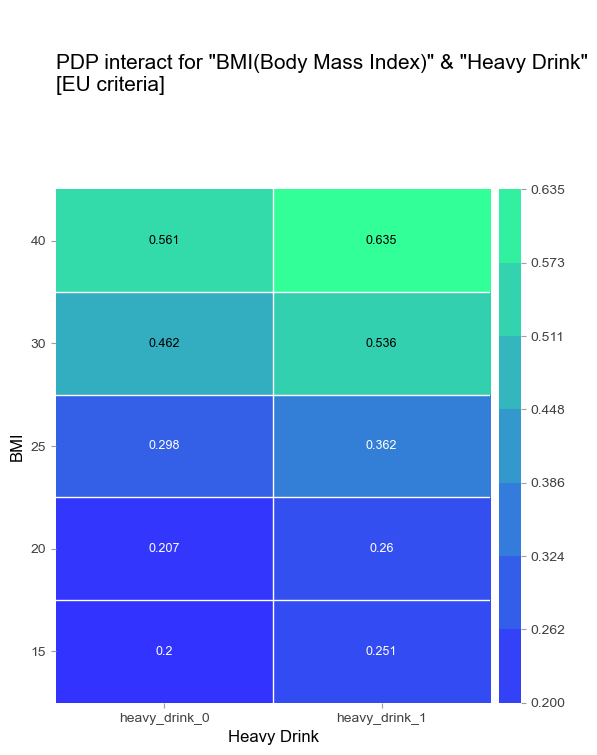

In [56]:
bmi_drink = ['heavy_drink','BMI']
pdp_bmi_drink_eu = pdp_interact(
    model=xgb_eu_tun,
    dataset=X_test,
    model_features=X_test.columns,
    features=bmi_drink,
    grid_types=['percentile','percentile'],
    cust_grid_points=[[0,1],
                      [15,20,25,30,40]]
)
pdp_interact_plot(
    pdp_bmi_drink_eu,
    figsize=(6,9),
    plot_type='grid',
    feature_names=['Heavy Drink','BMI'],
    plot_params={
        'title':'PDP interact for "BMI(Body Mass Index)" & "Heavy Drink"\n[EU criteria]',
        'subtitle':'',
        'cmap':'winter',
    })
plt.show()